## 1. Imports

In [14]:
import os
import glob
import numpy as np
import pandas as pd
from torchvision import transforms
from torchvision.transforms import InterpolationMode

from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from scipy.ndimage import label

import weak_annotator

## 2. Bounding Box

In [45]:
# 0. Initialize base path and pattern
base_path = r'C:\Users\wendy\Desktop\Studies\DTU\Year 1 - Fall\02516 - Intro 2 DL in CV\Projects\Project 3\PH2_Dataset_images'
pattern = os.path.join(base_path, 'IMD???', 'IMD???_lesion', 'IMD???_lesion.bmp')

resize_dim = None
# resize_dim = (576, 768)

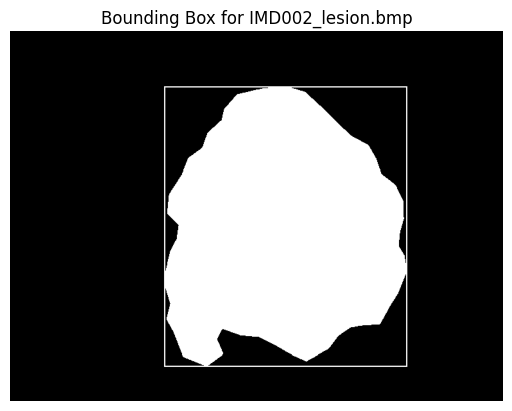

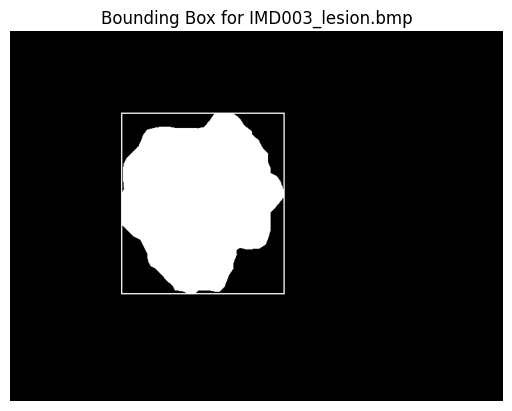

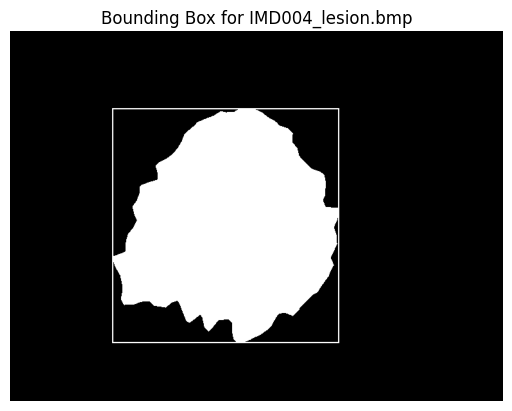

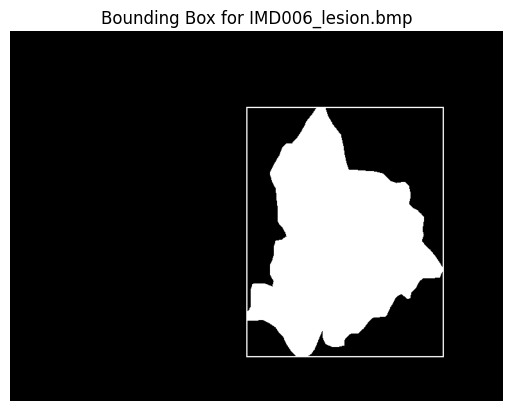

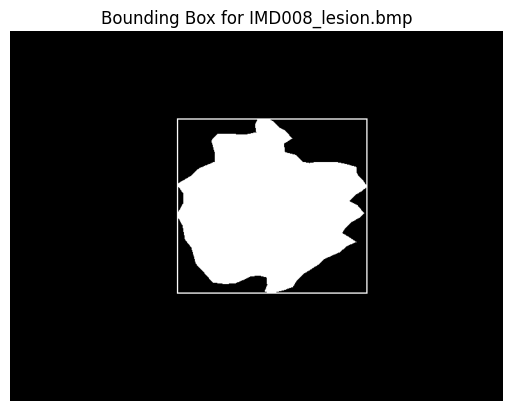

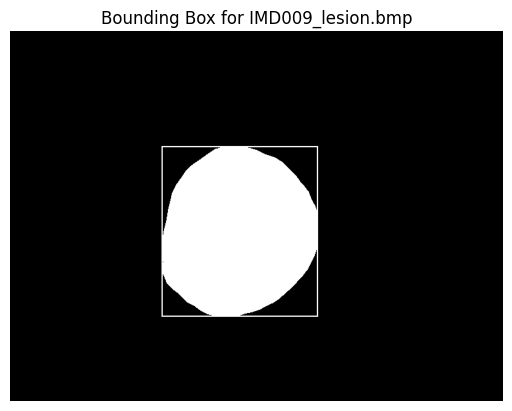

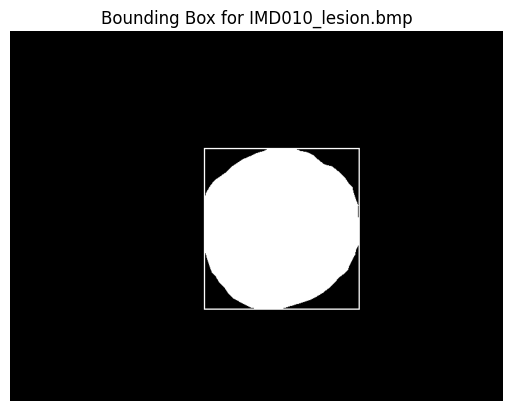

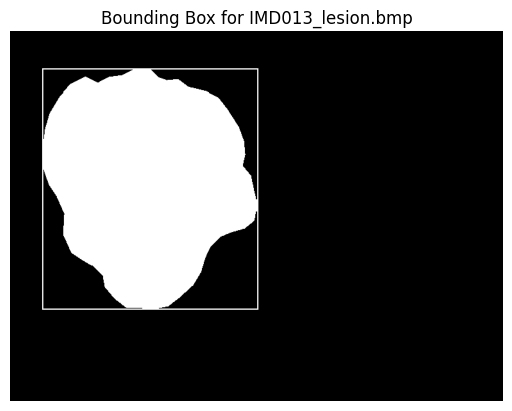

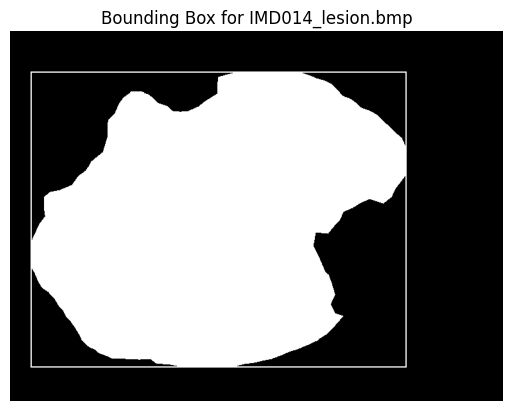

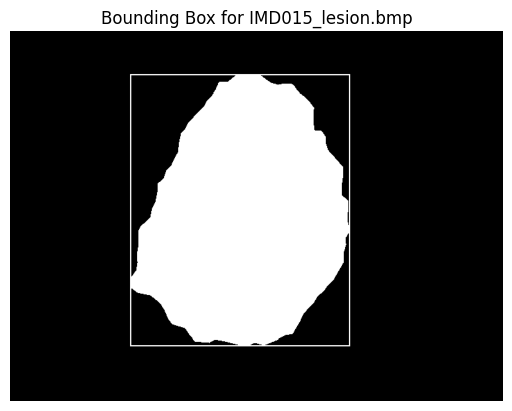

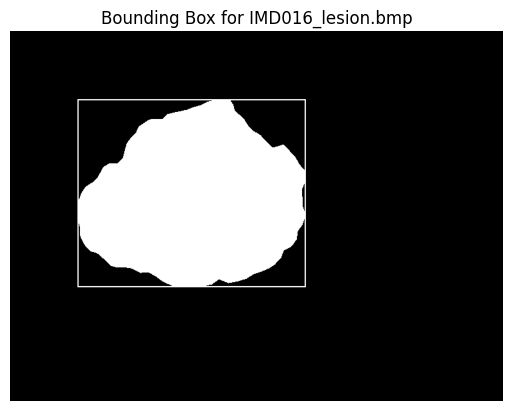

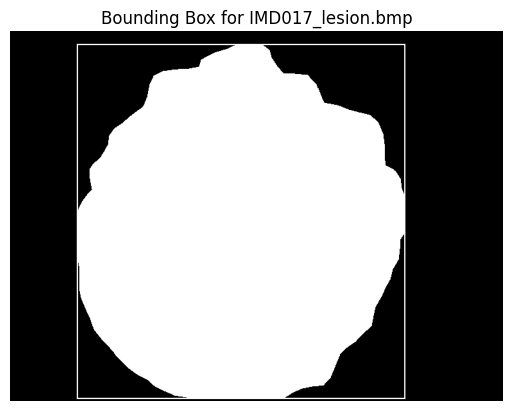

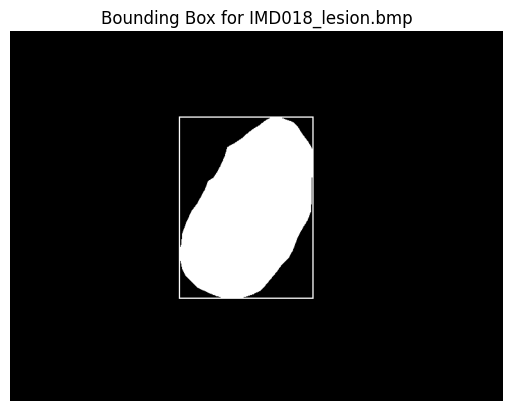

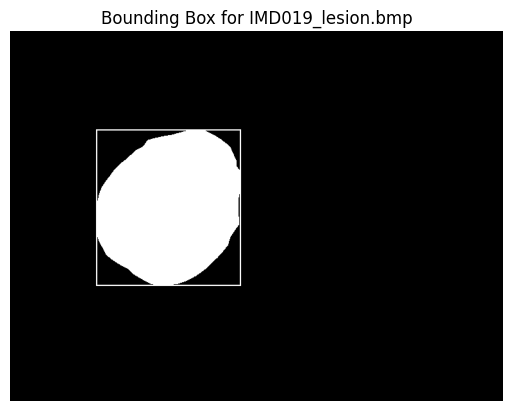

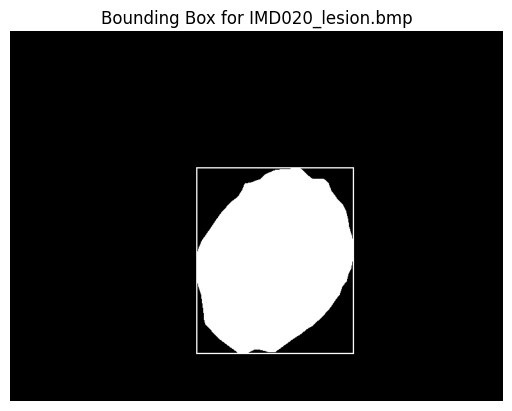

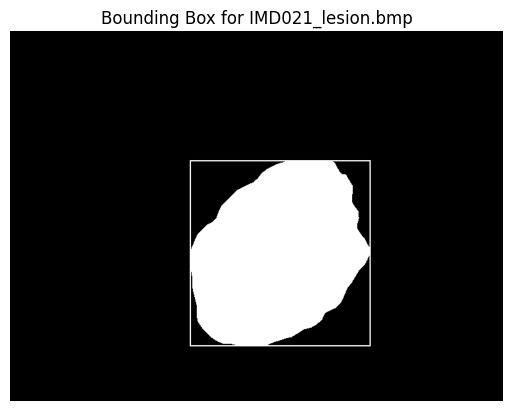

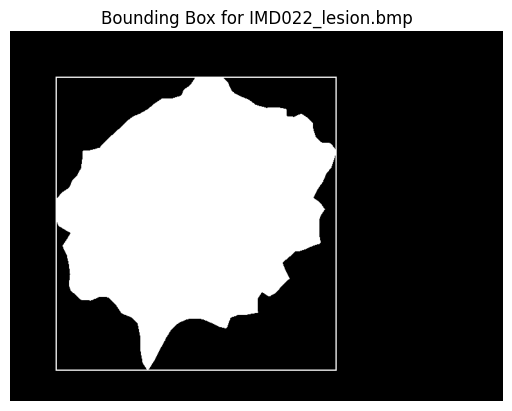

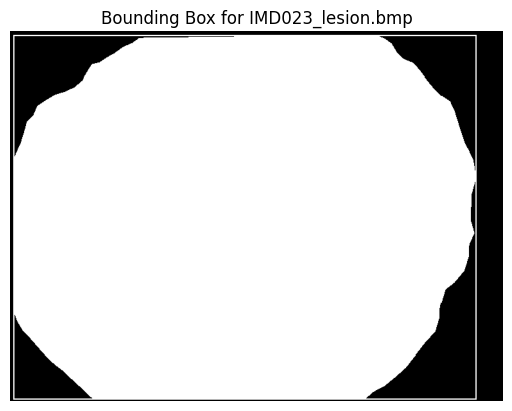

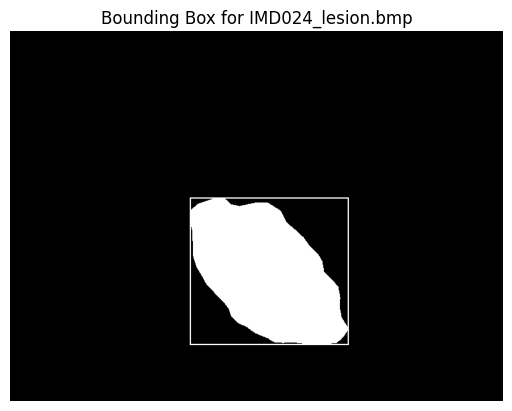

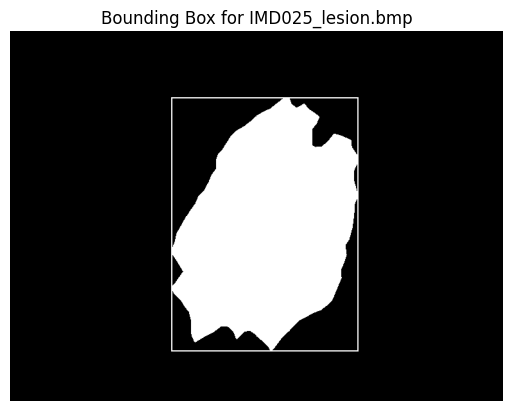

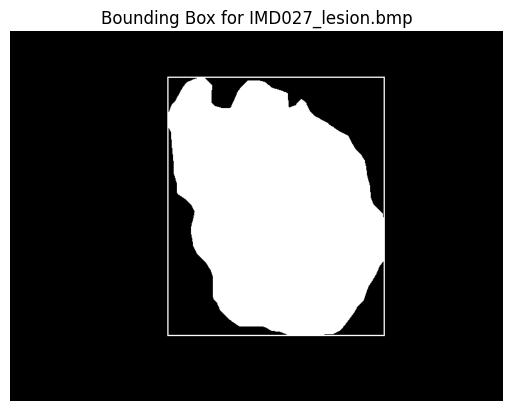

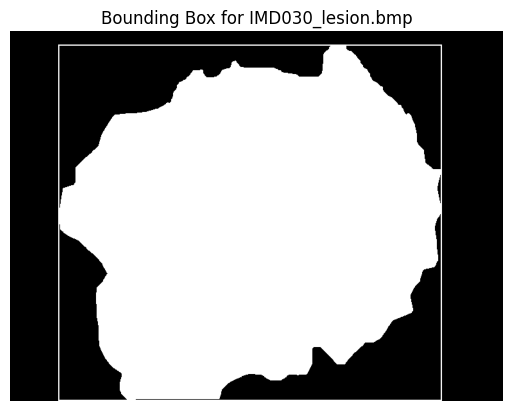

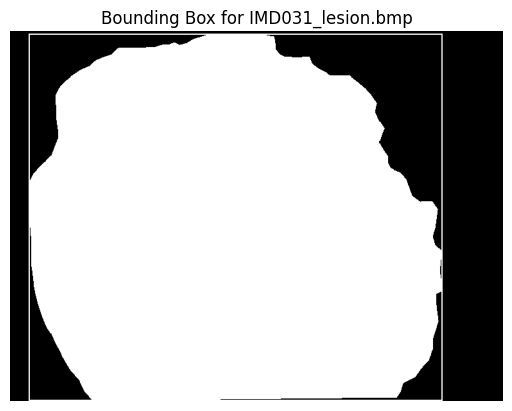

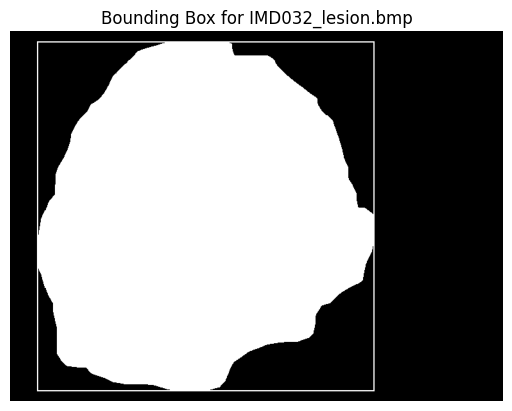

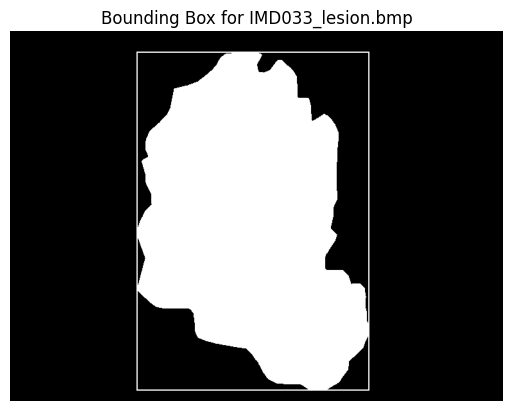

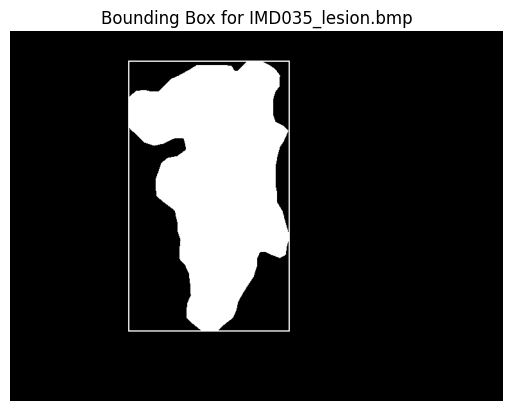

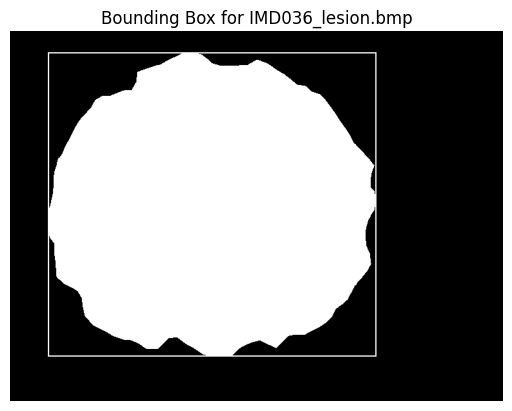

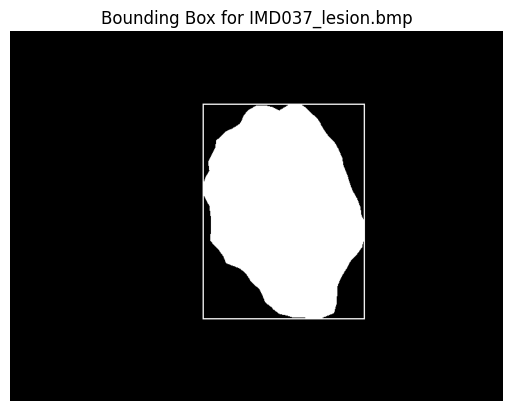

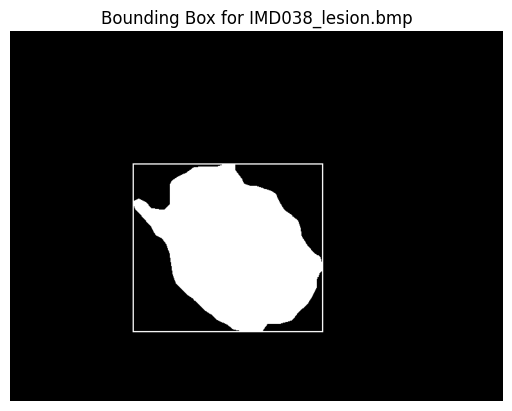

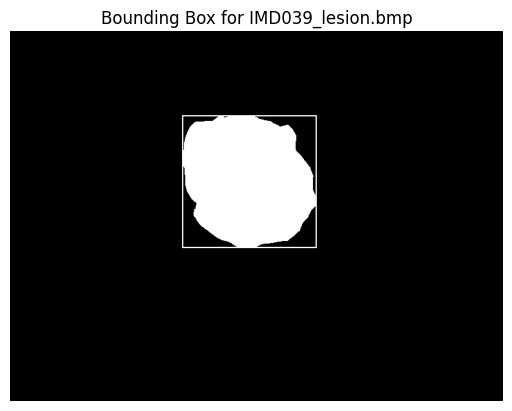

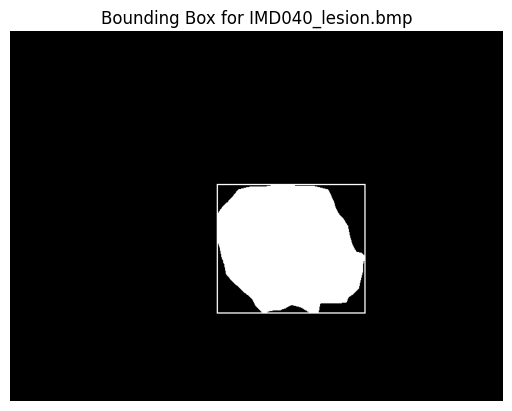

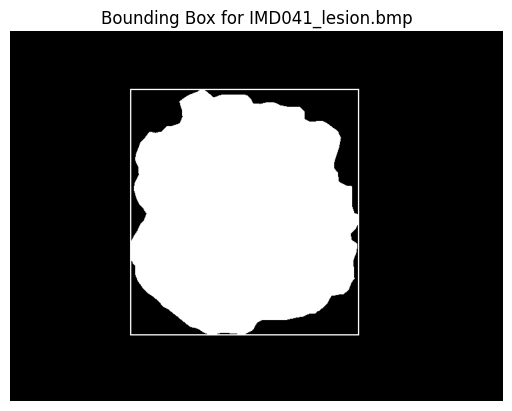

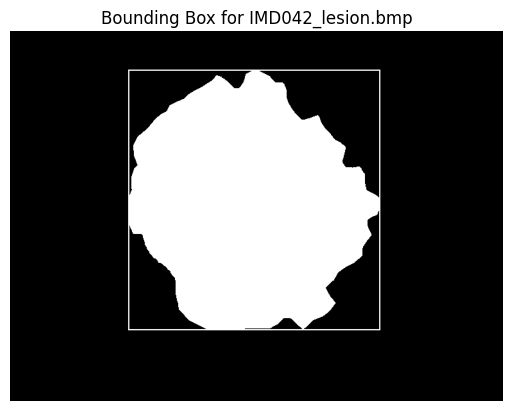

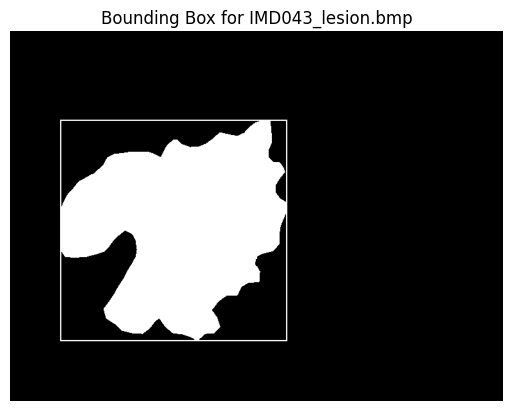

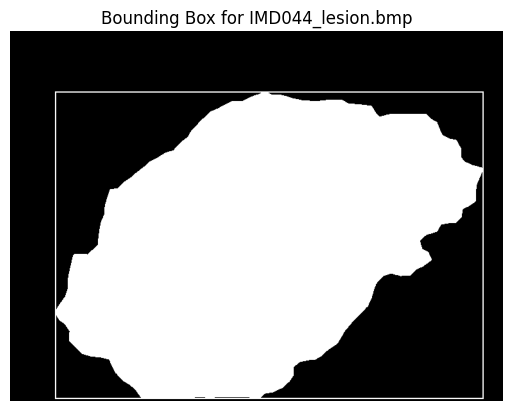

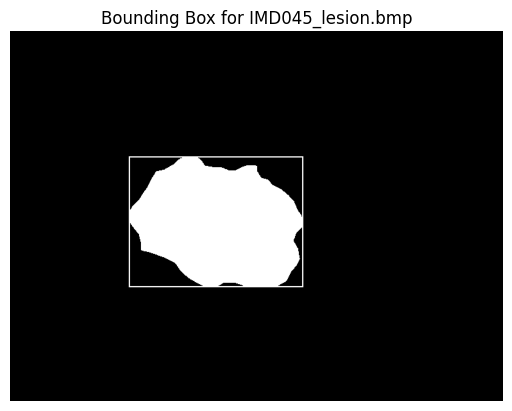

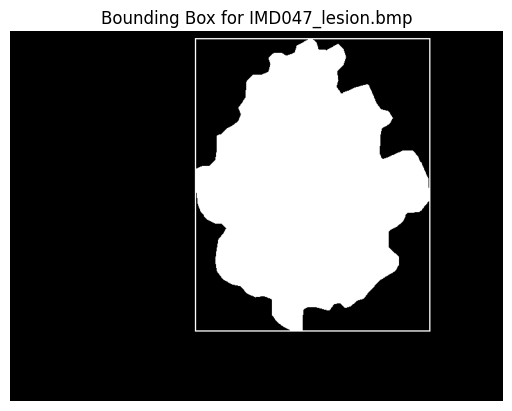

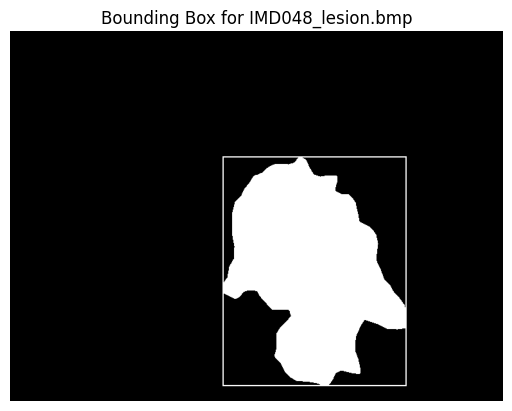

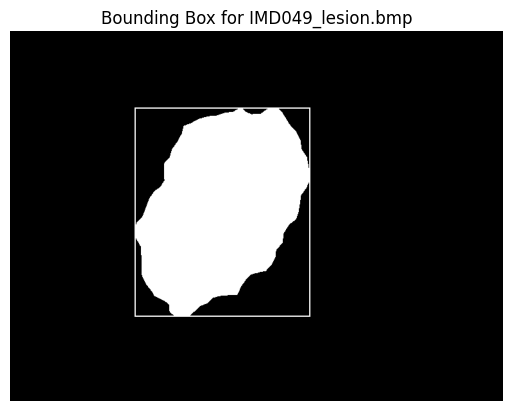

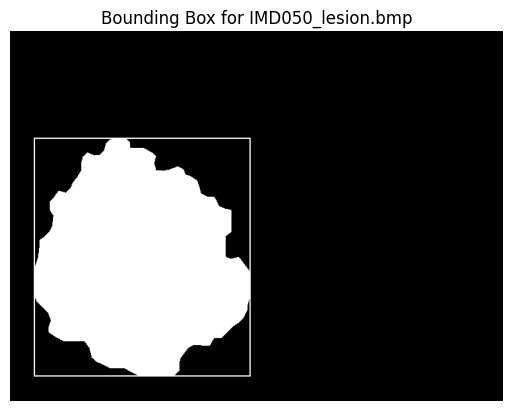

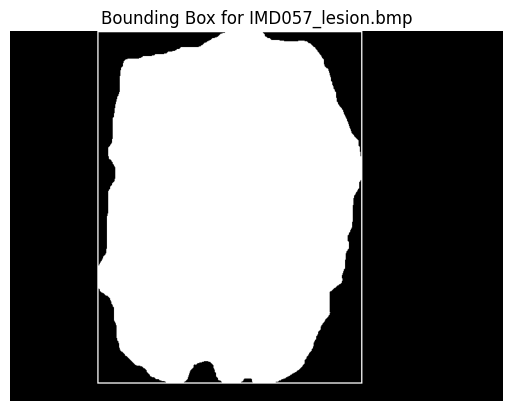

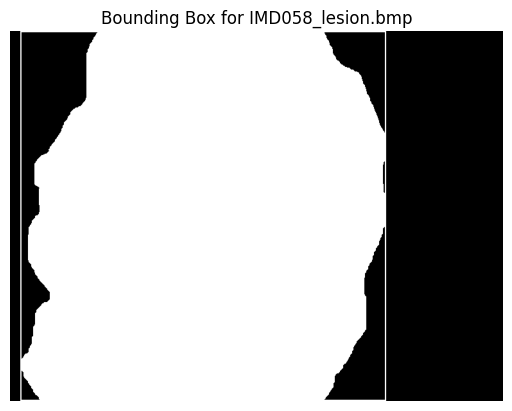

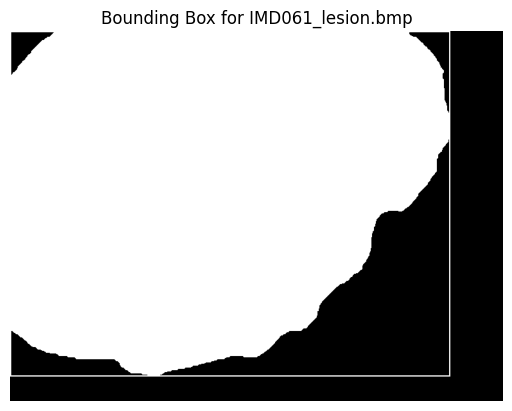

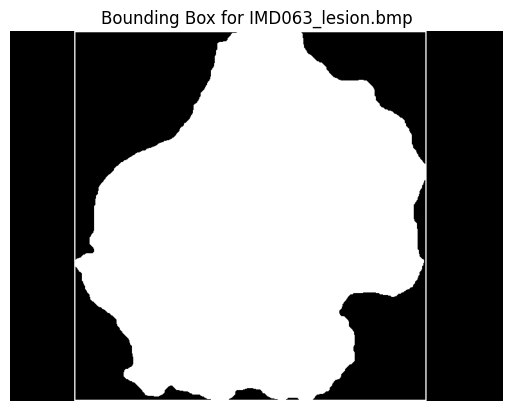

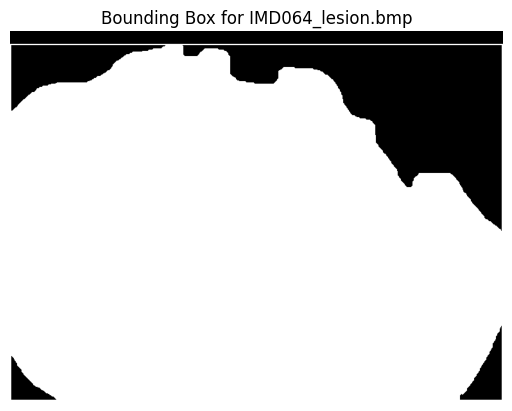

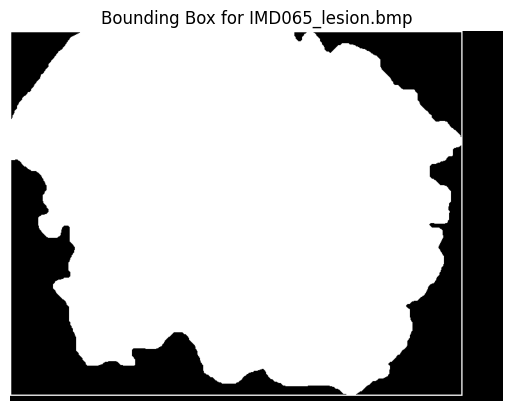

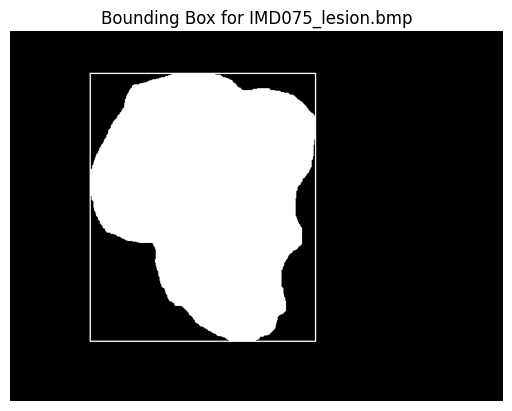

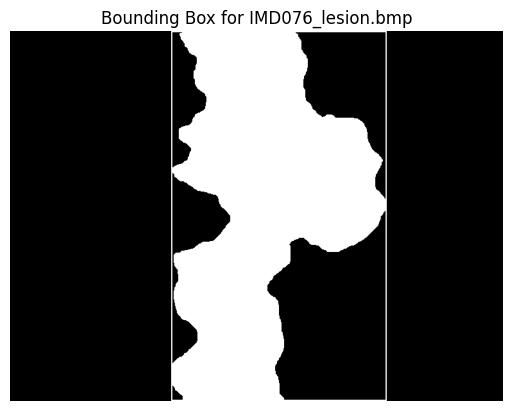

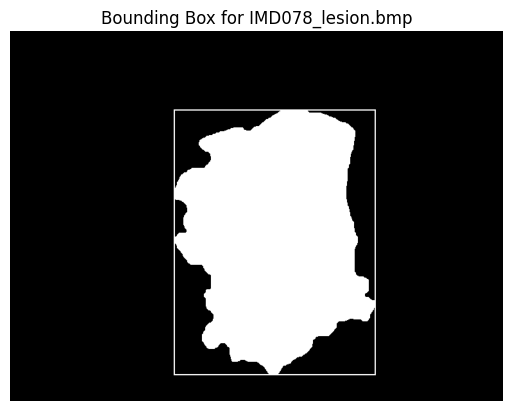

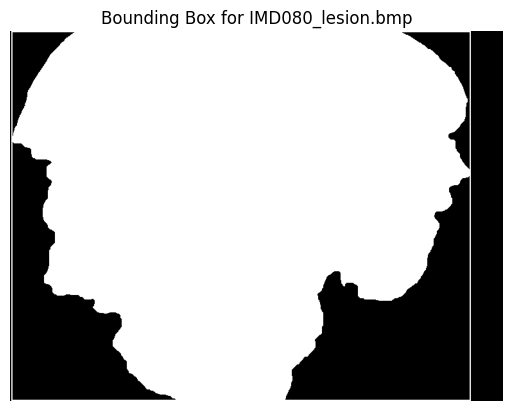

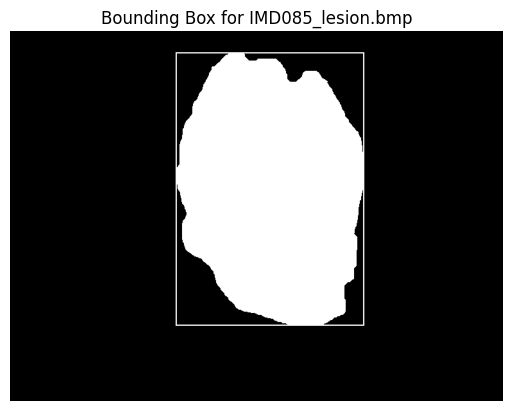

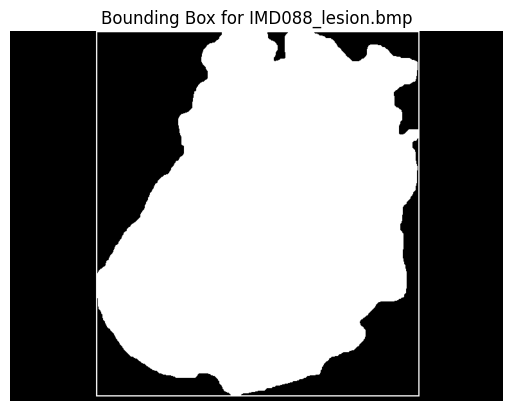

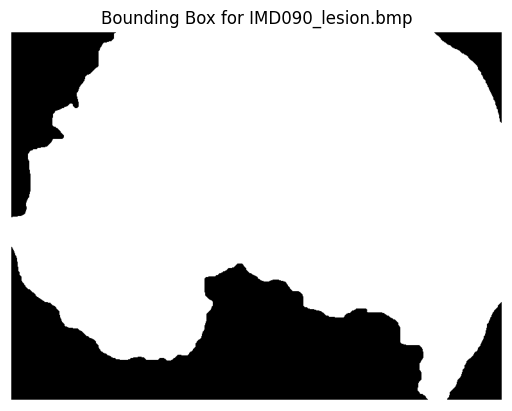

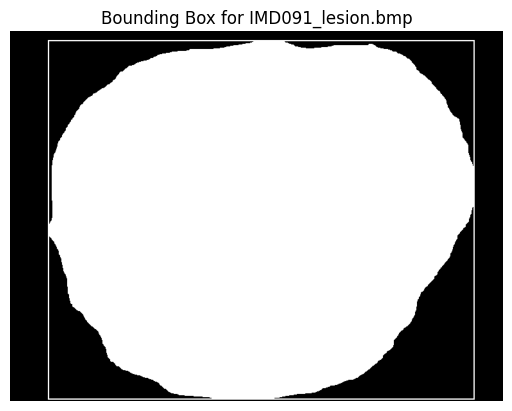

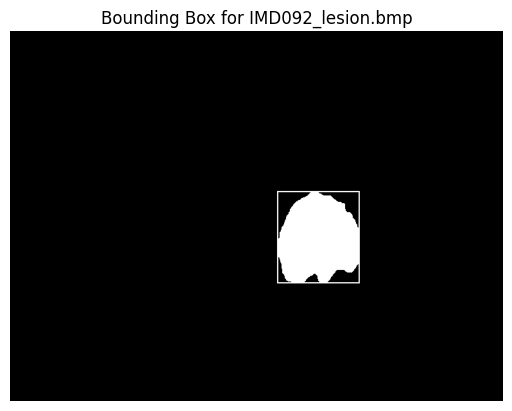

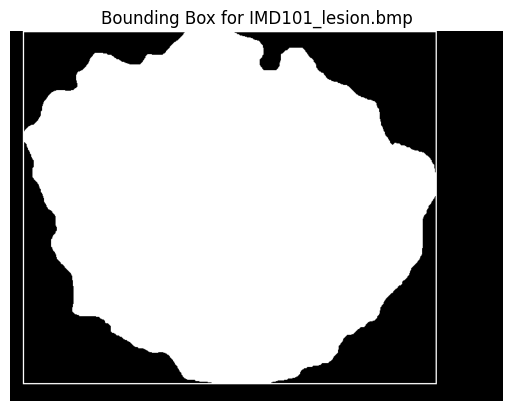

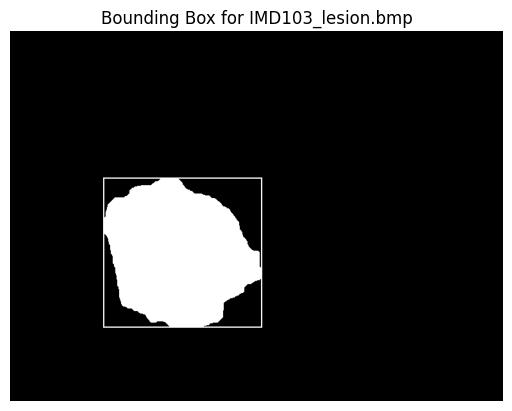

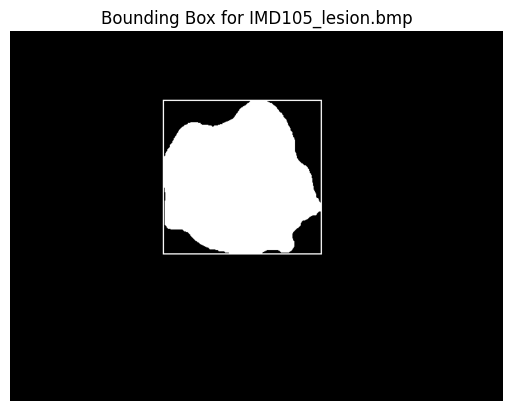

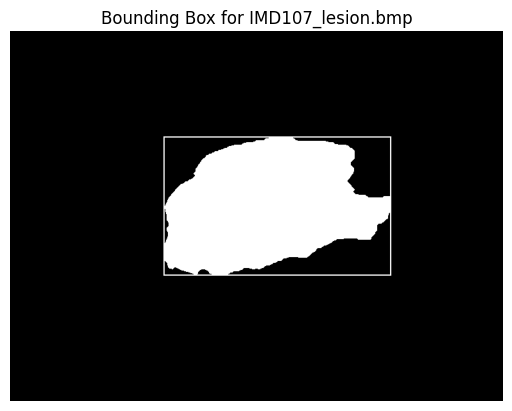

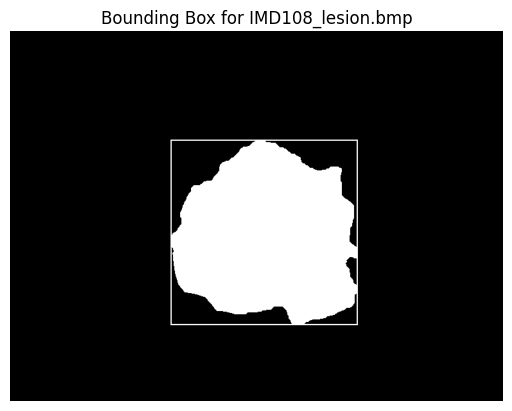

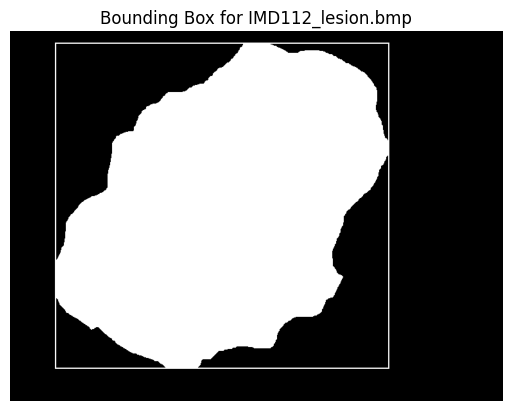

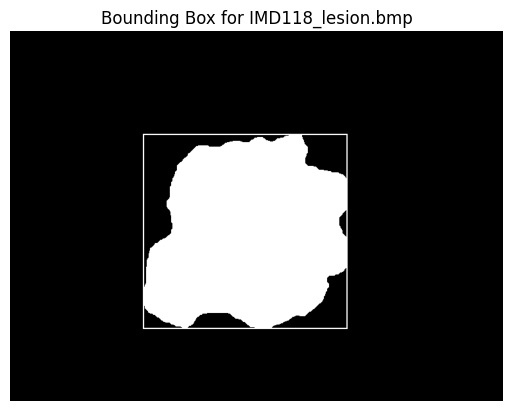

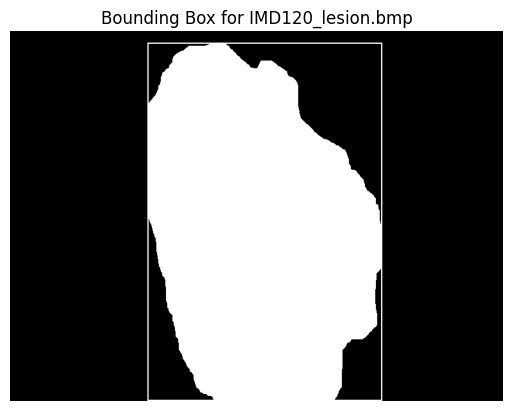

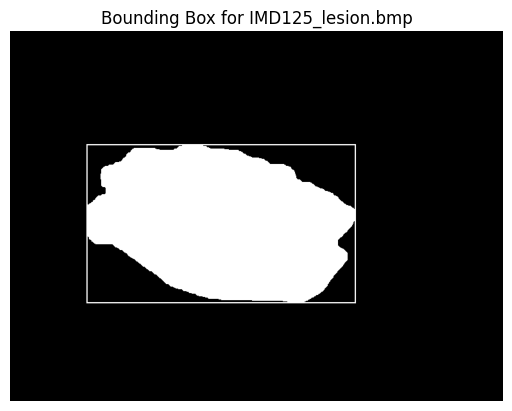

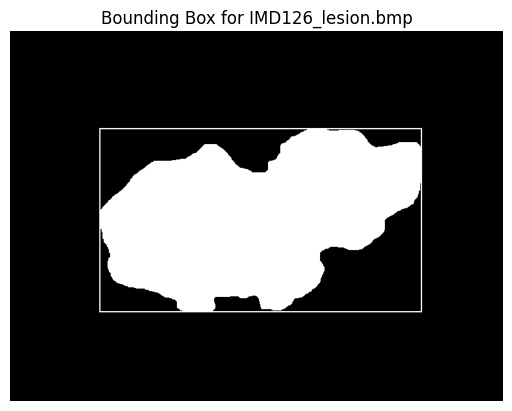

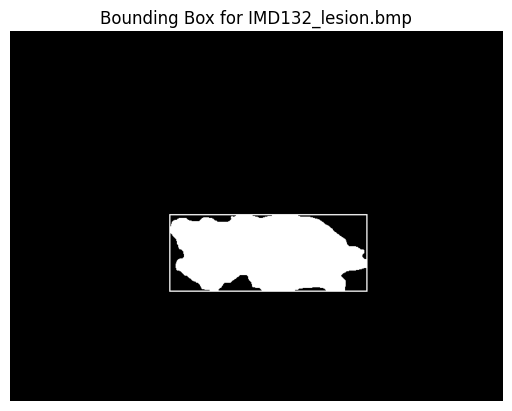

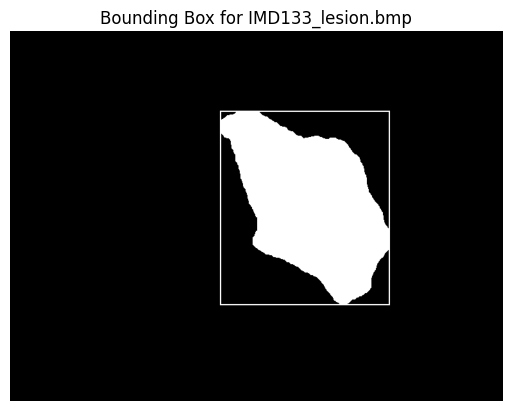

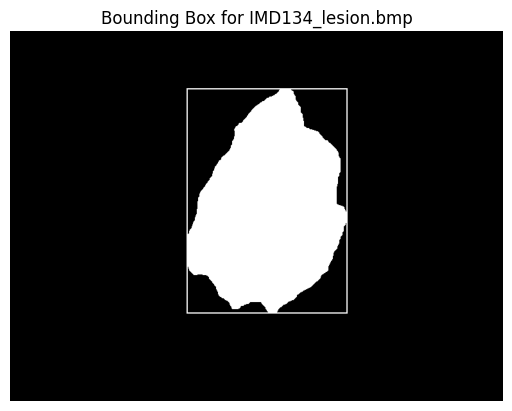

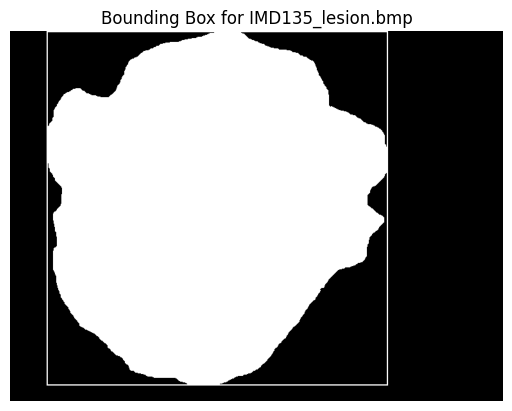

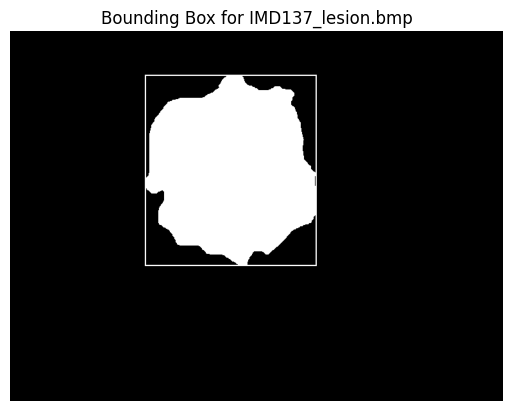

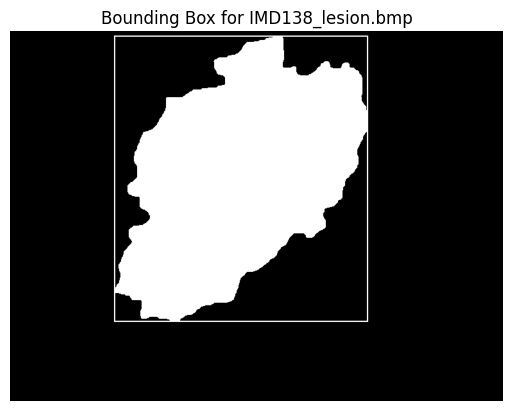

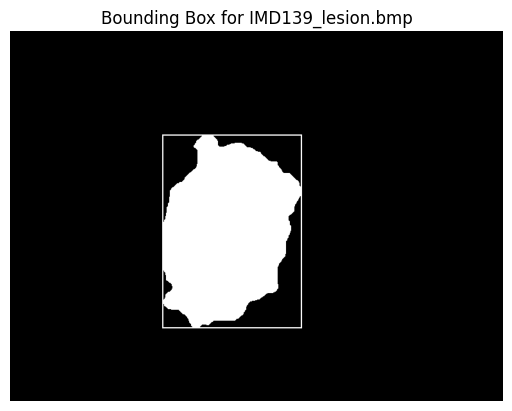

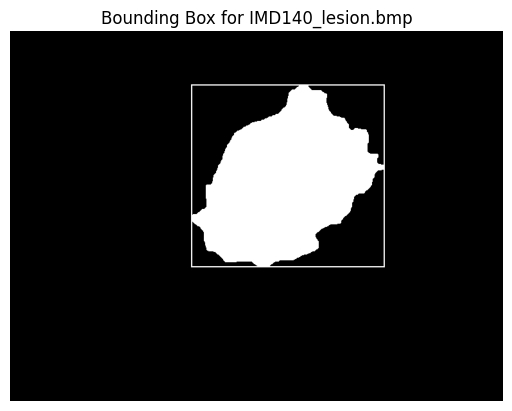

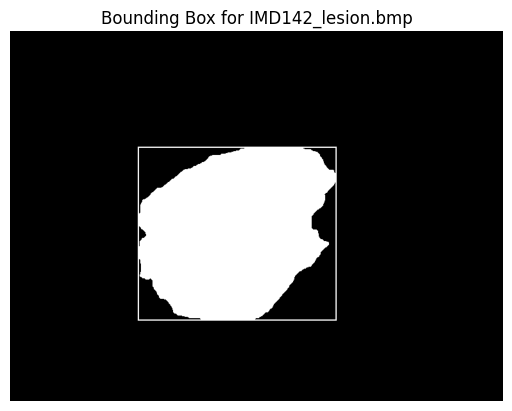

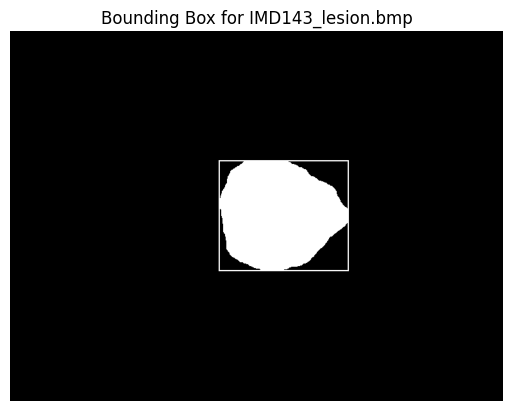

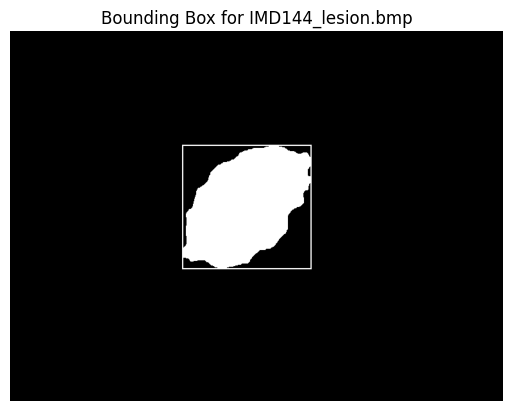

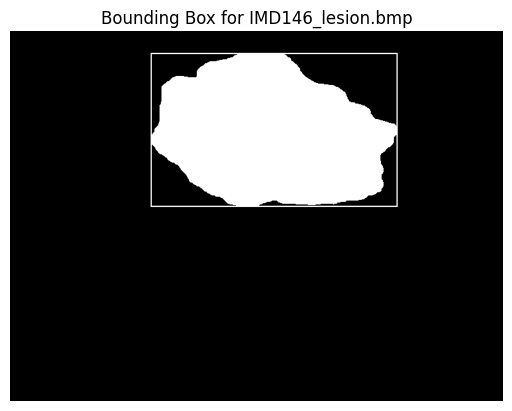

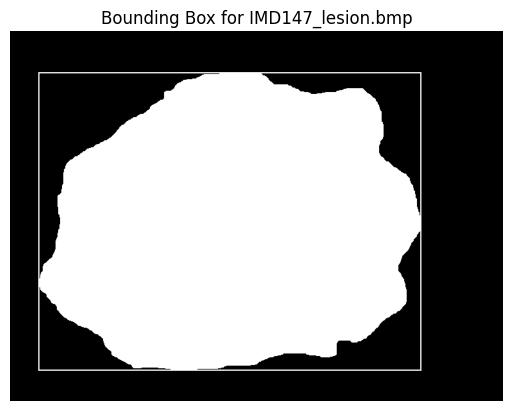

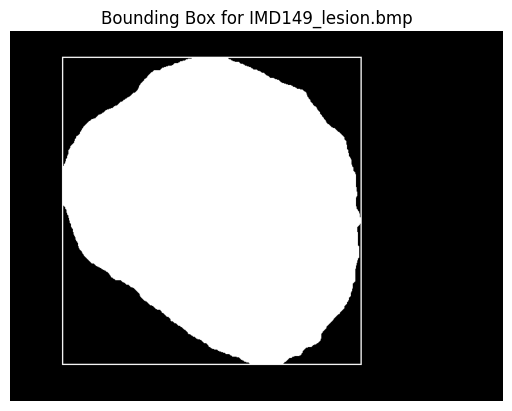

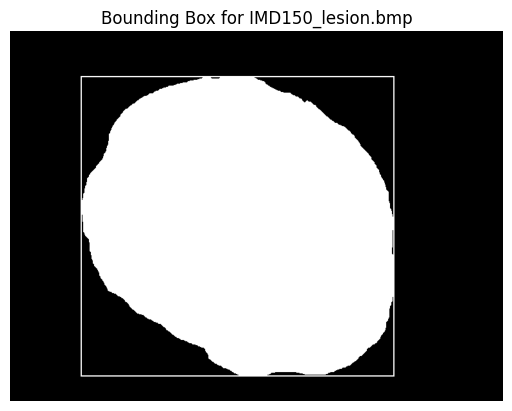

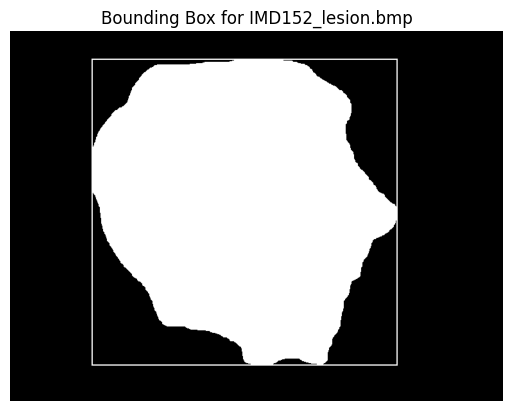

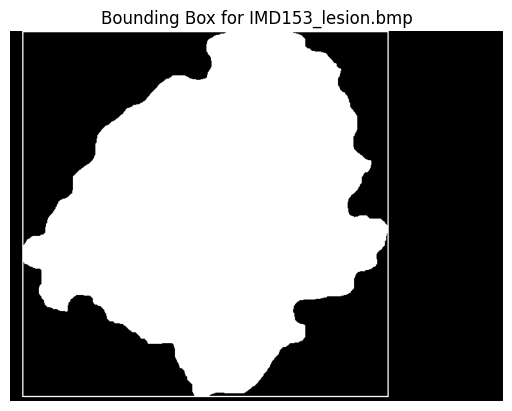

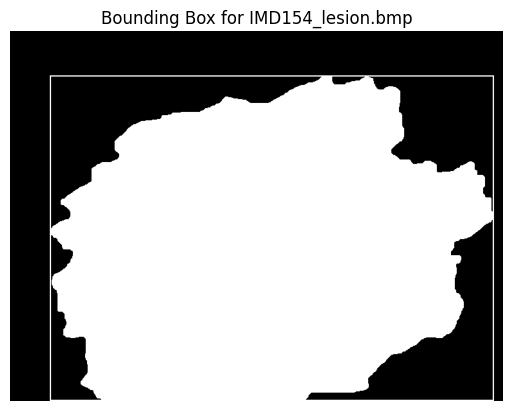

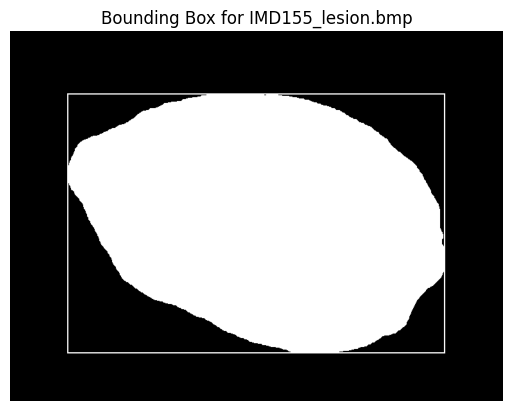

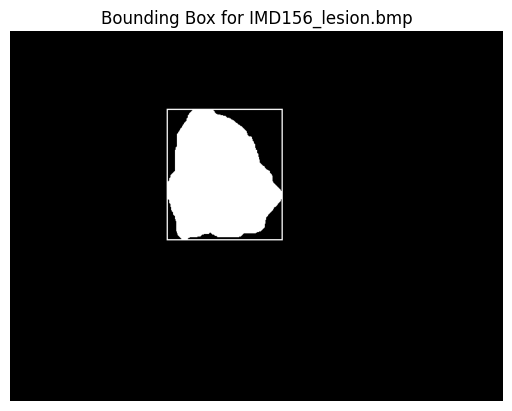

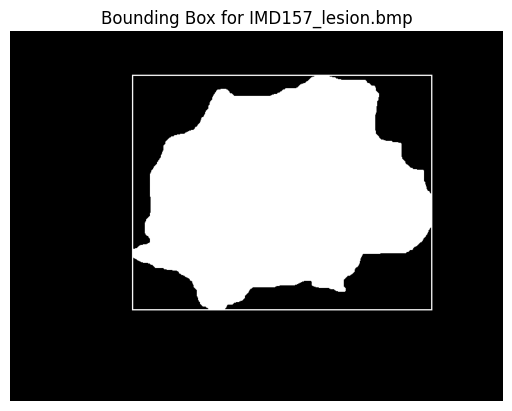

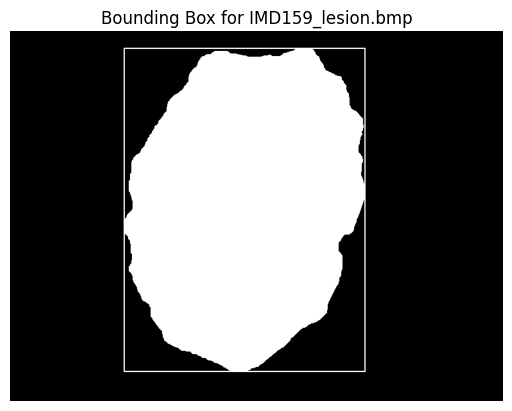

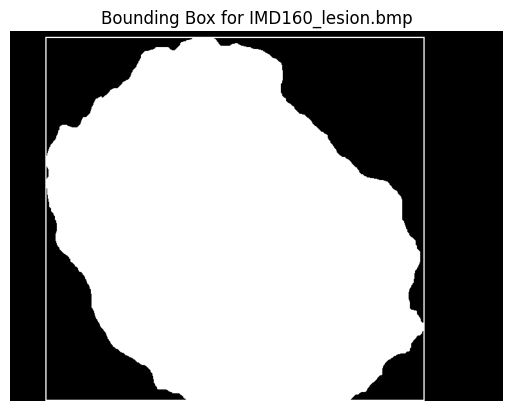

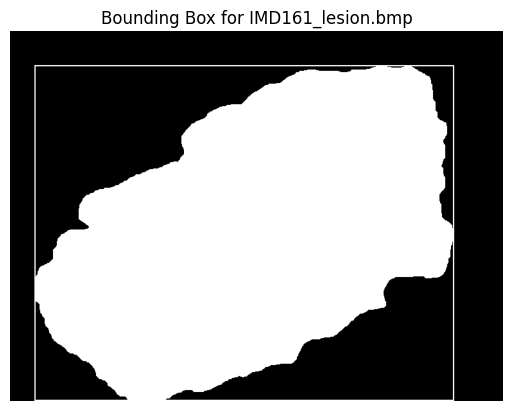

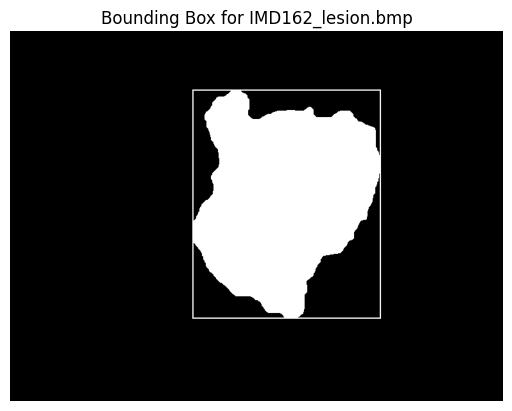

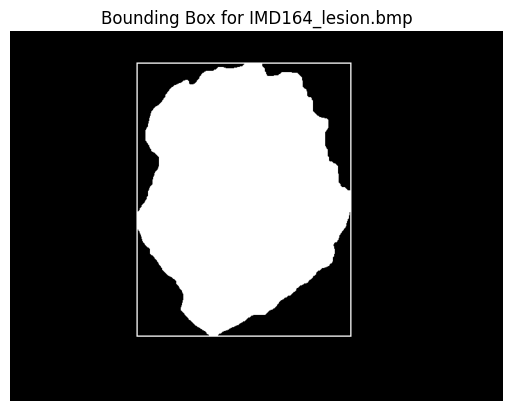

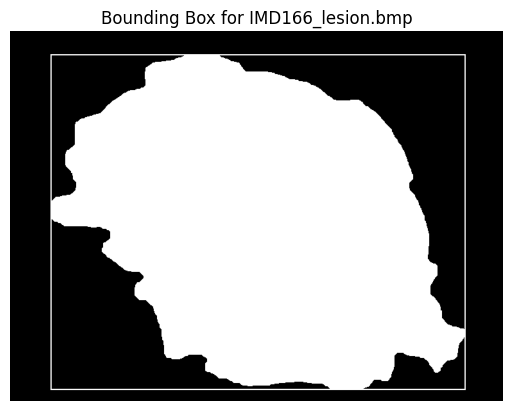

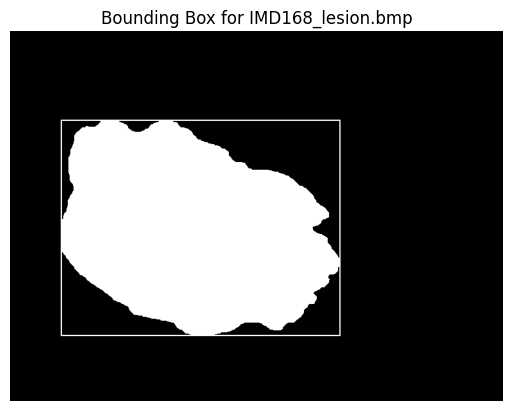

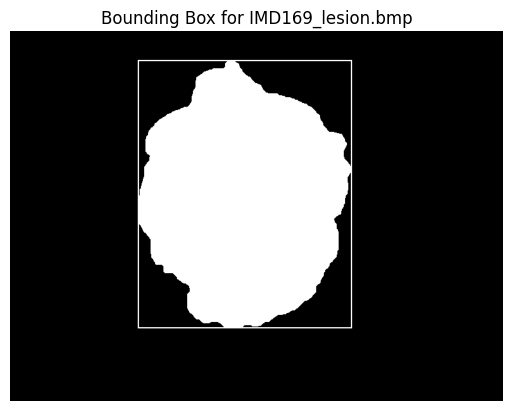

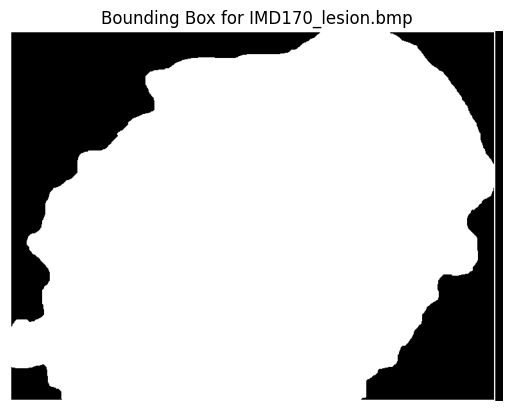

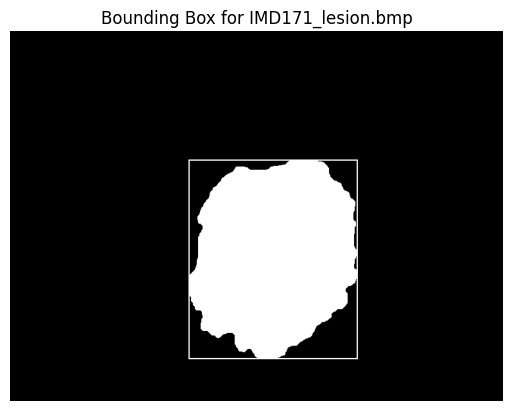

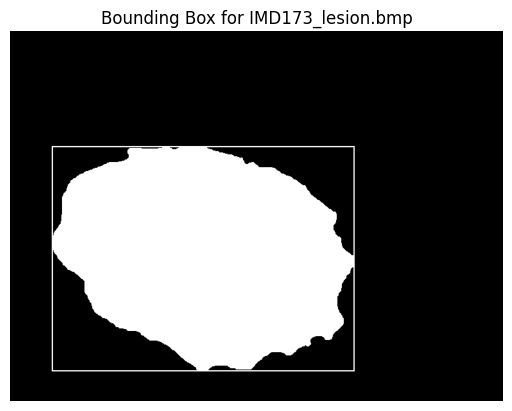

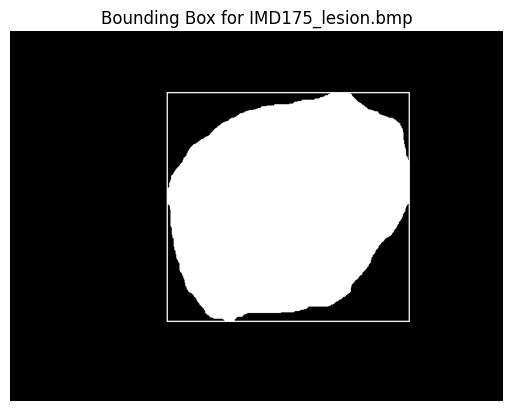

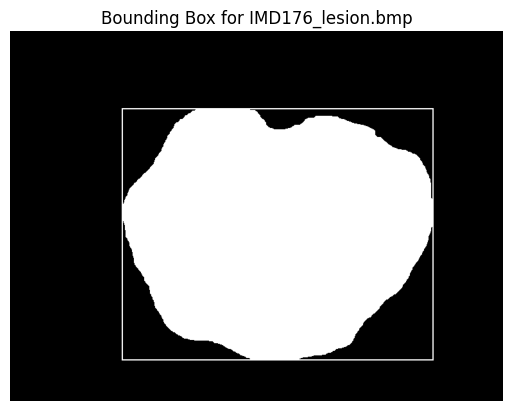

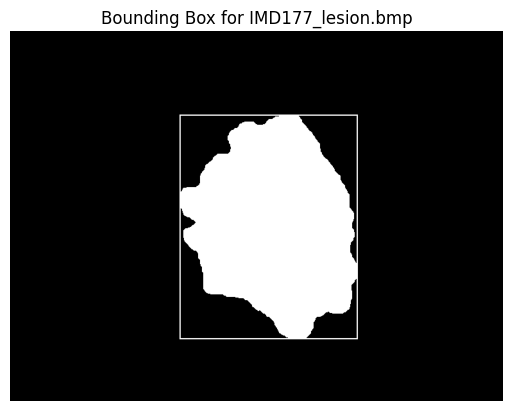

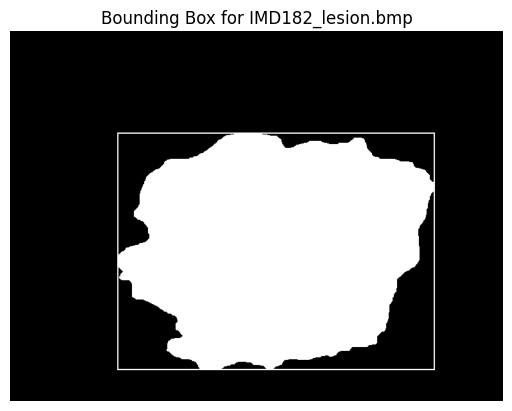

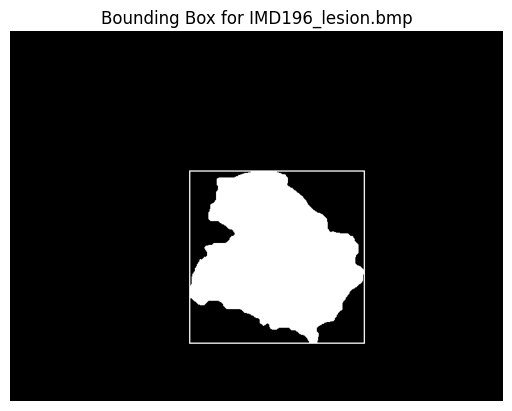

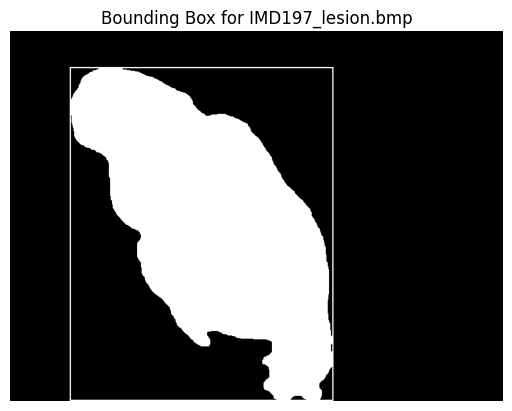

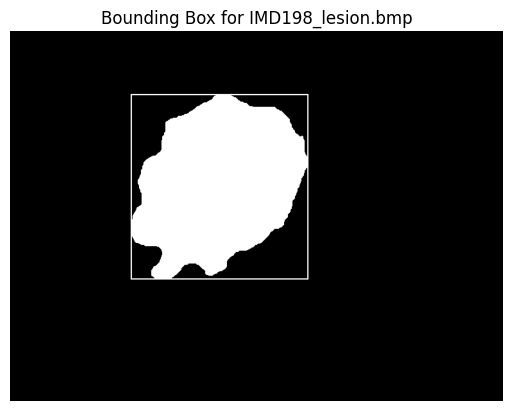

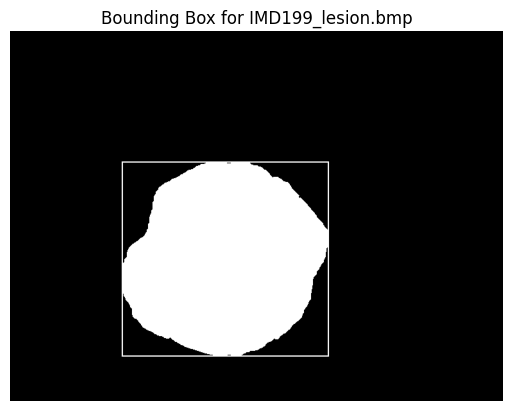

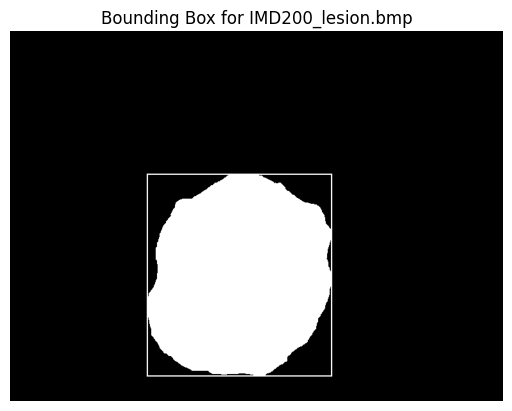

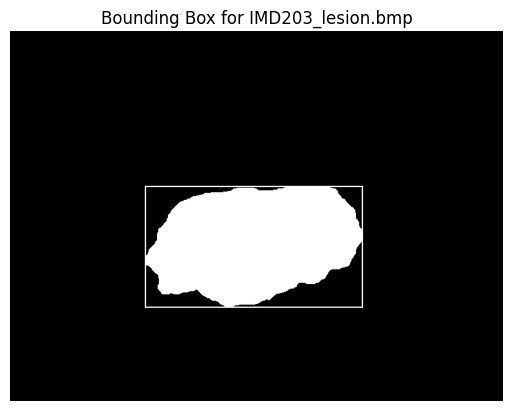

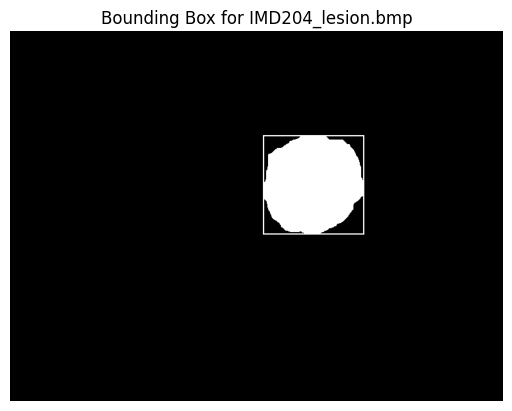

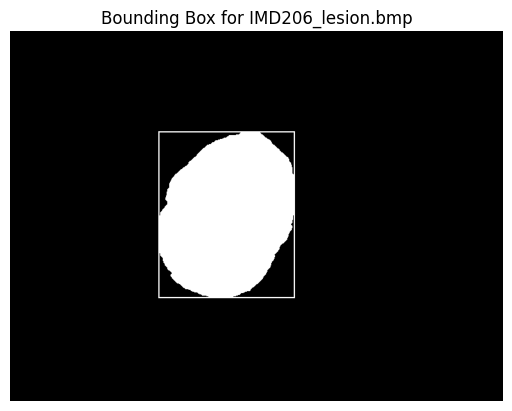

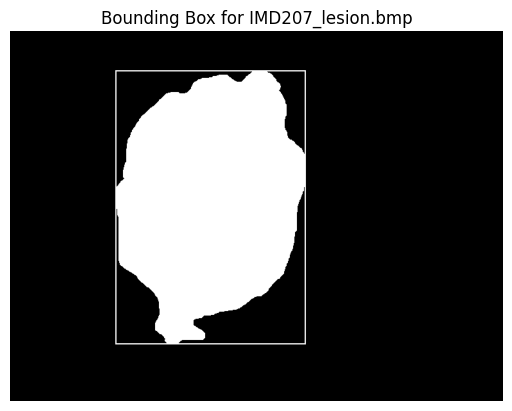

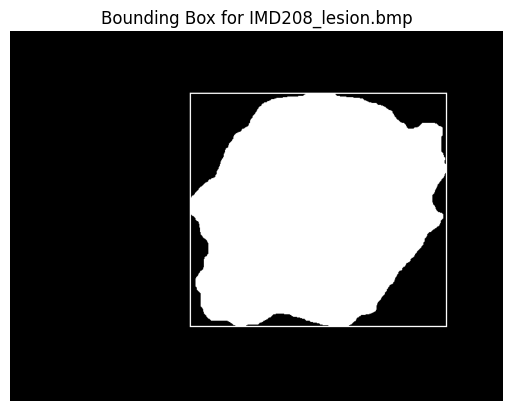

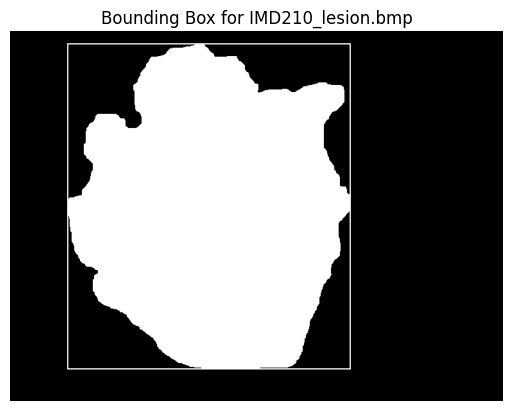

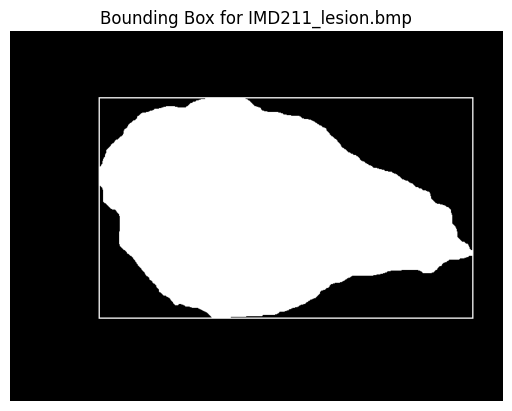

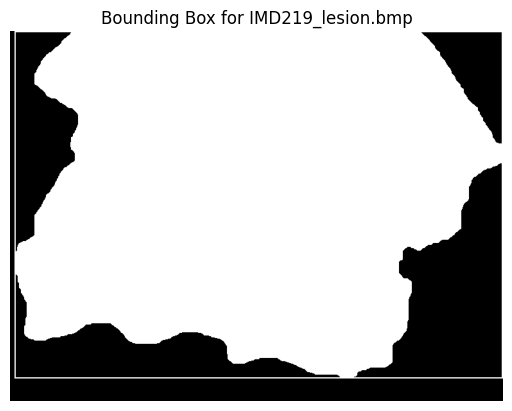

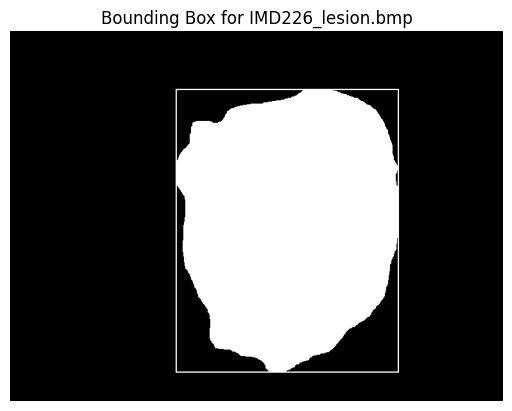

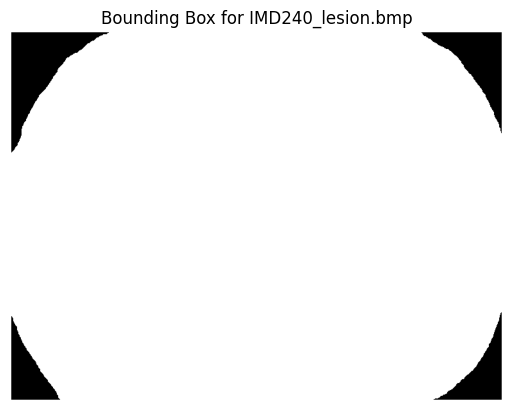

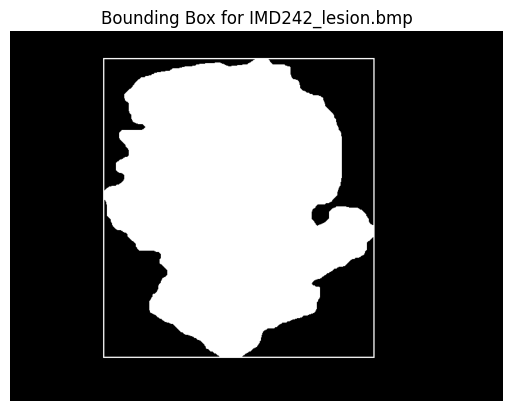

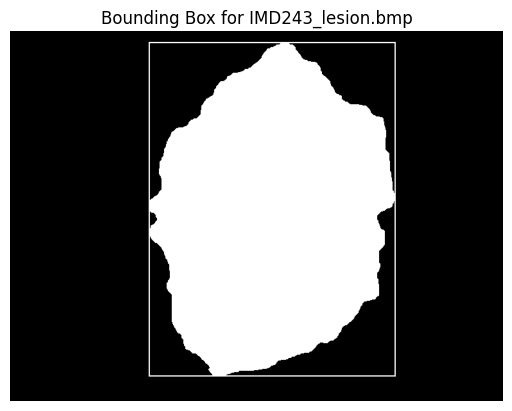

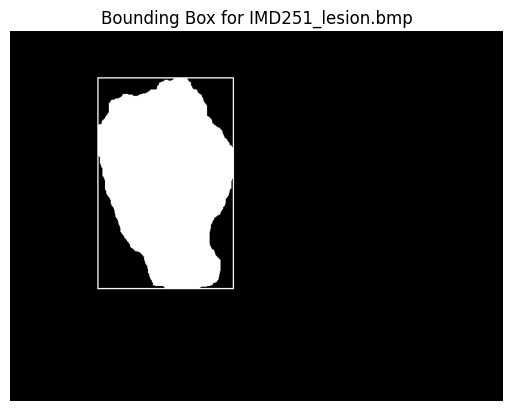

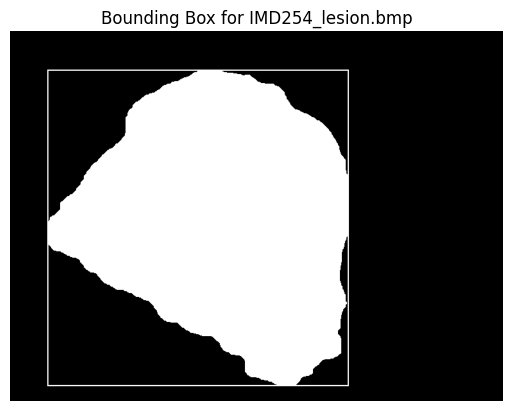

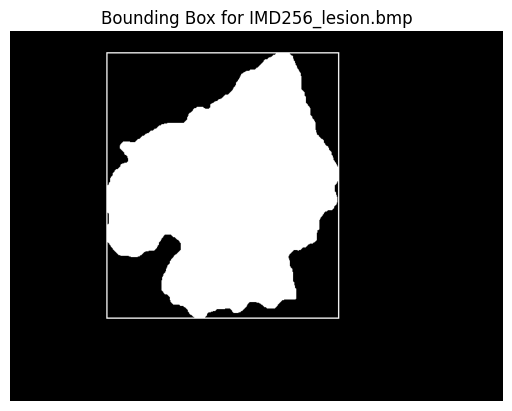

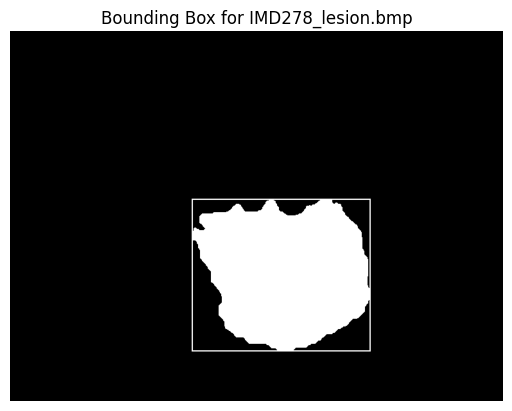

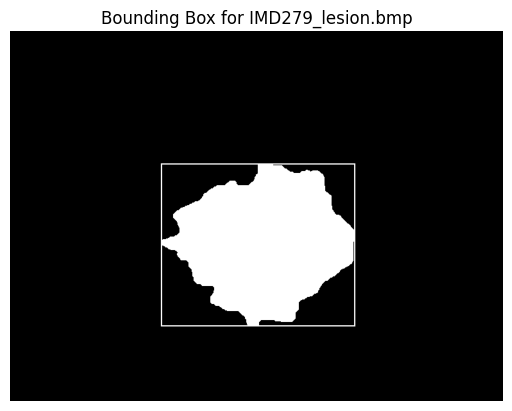

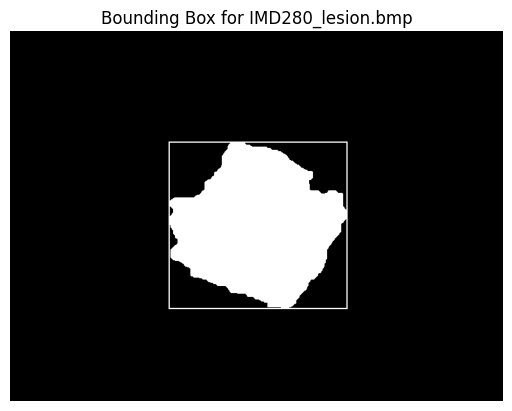

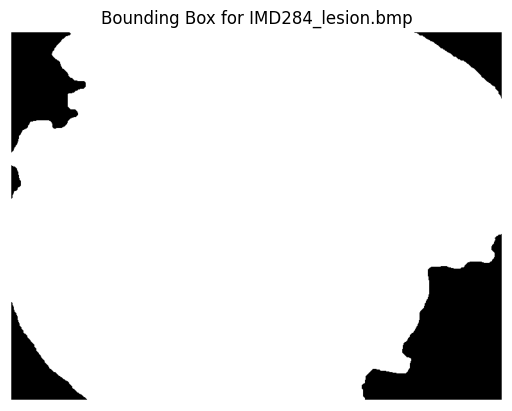

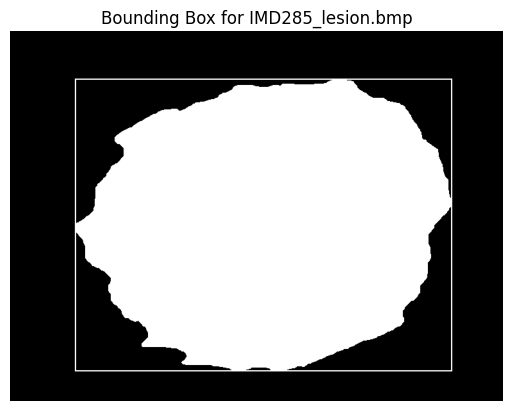

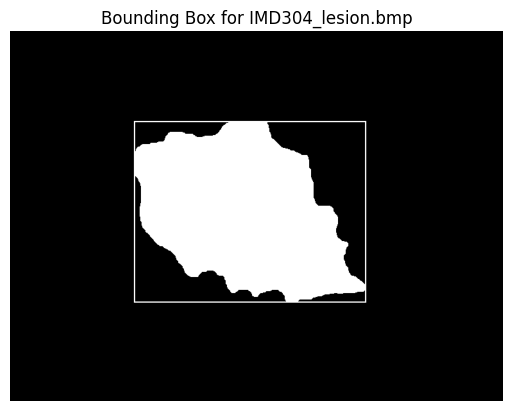

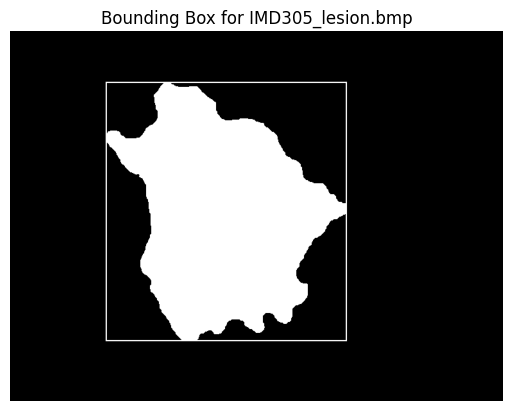

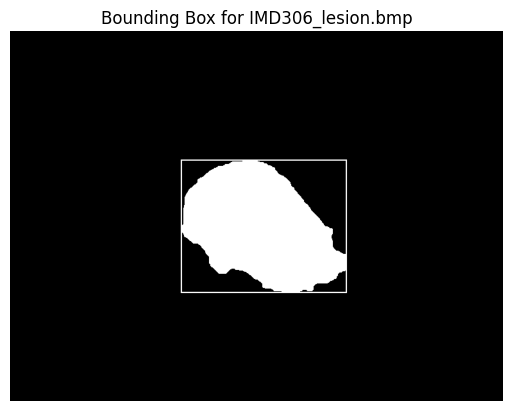

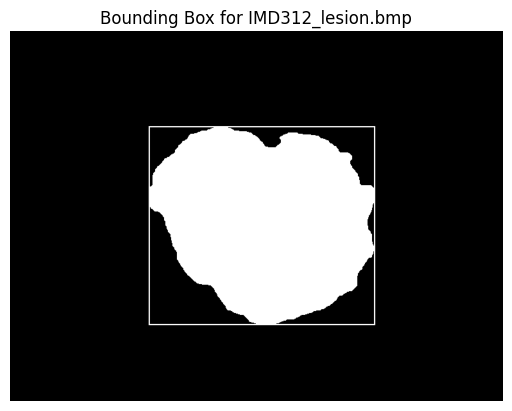

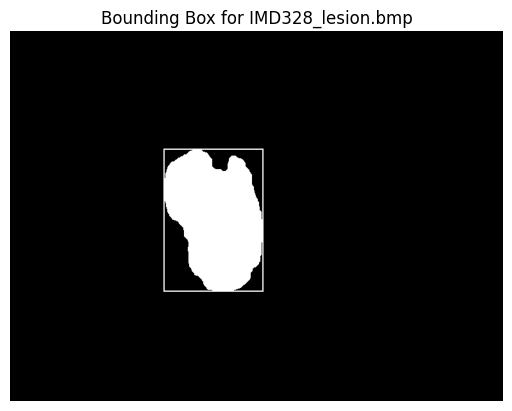

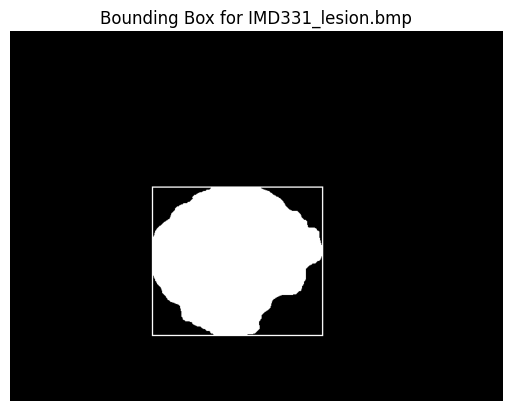

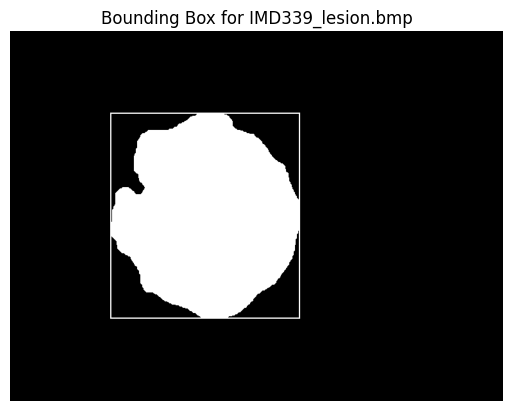

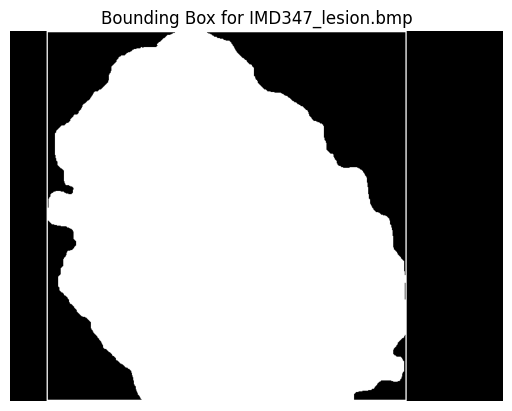

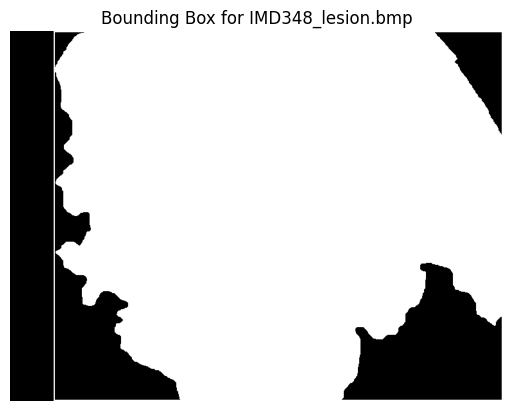

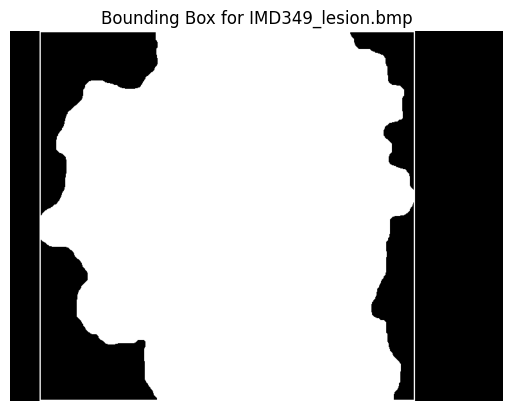

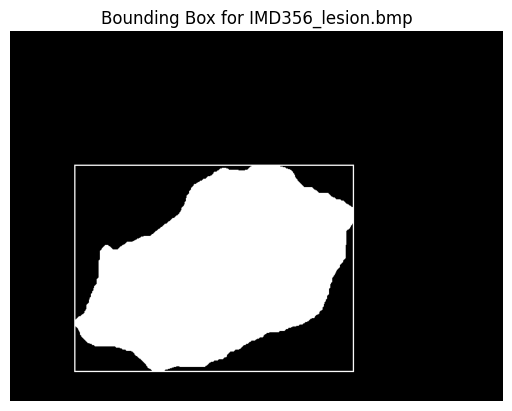

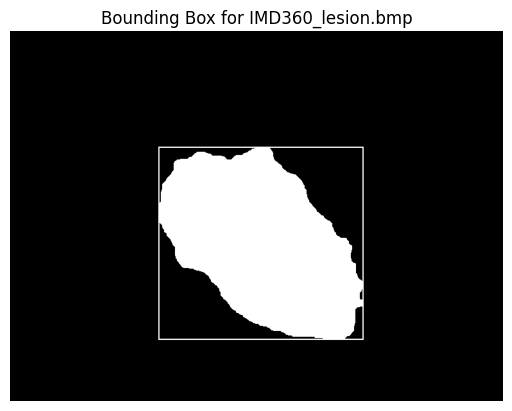

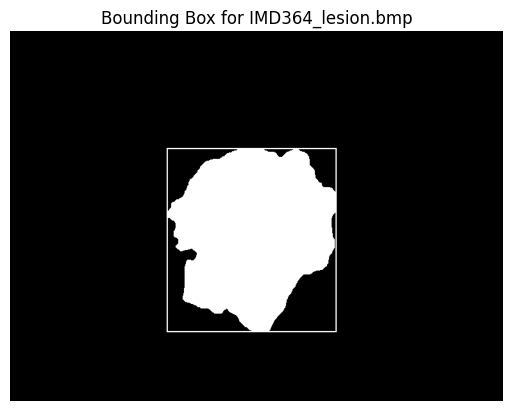

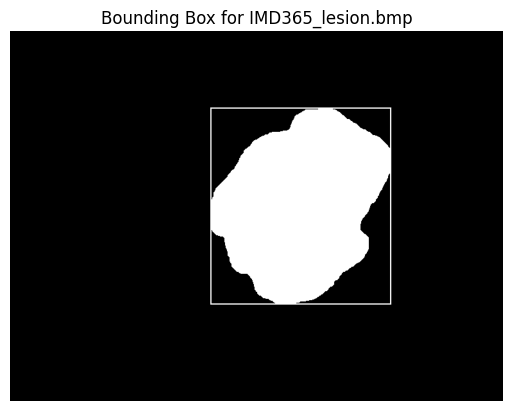

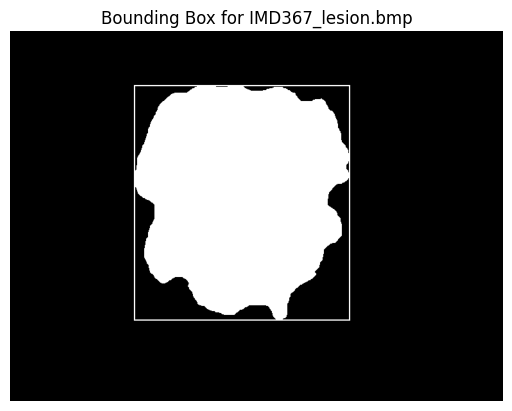

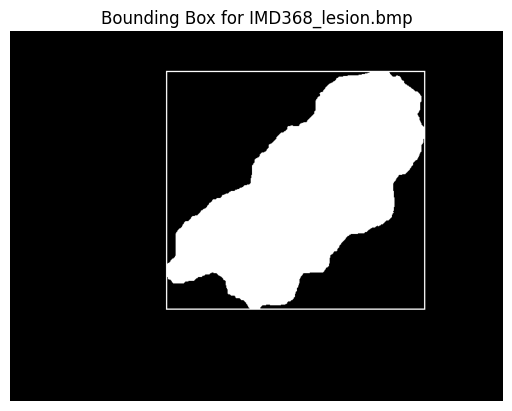

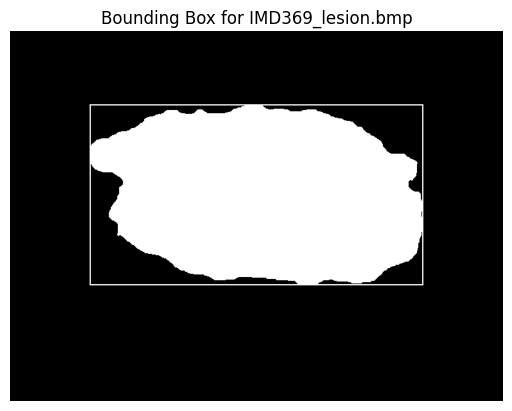

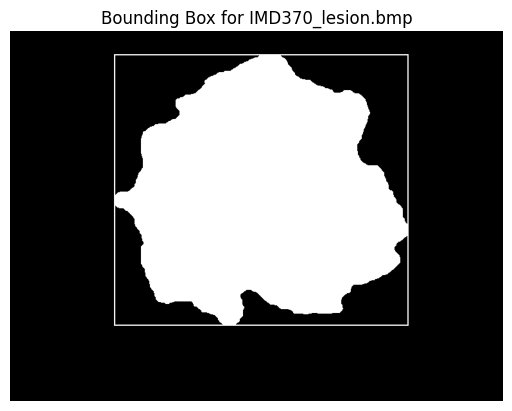

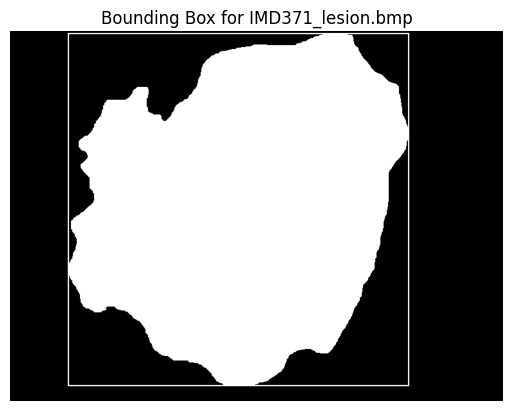

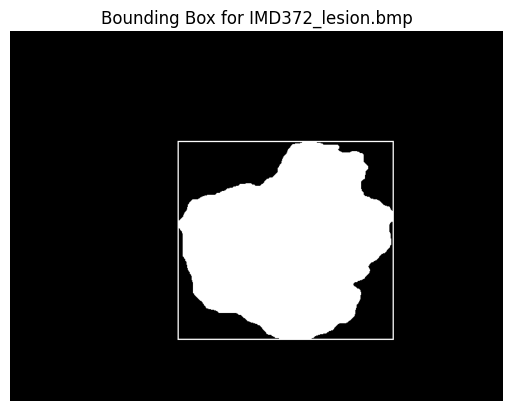

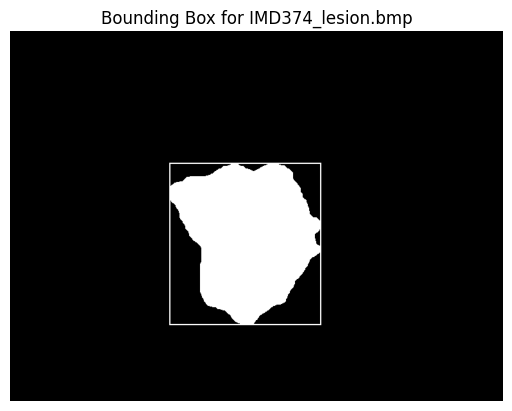

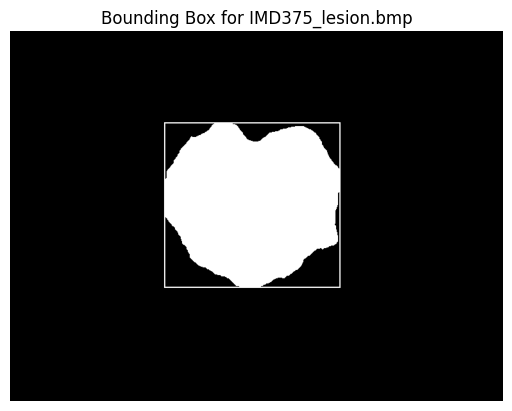

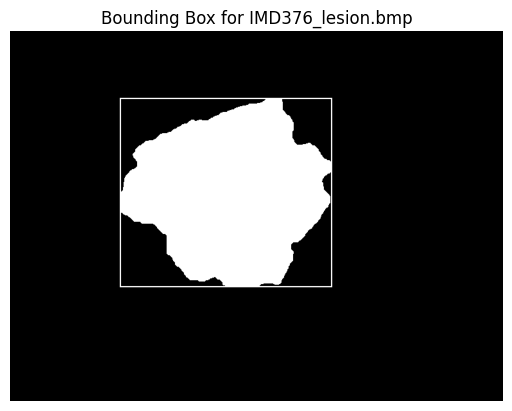

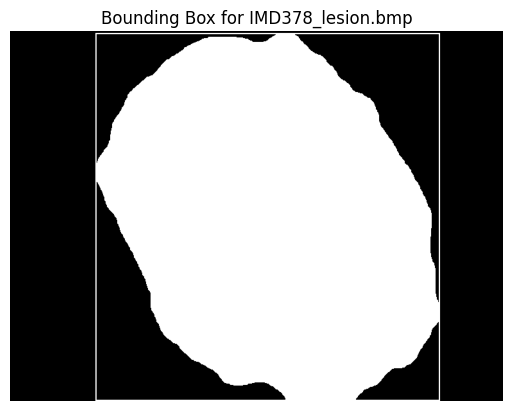

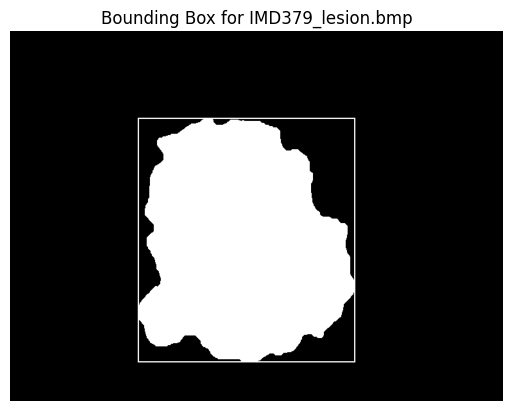

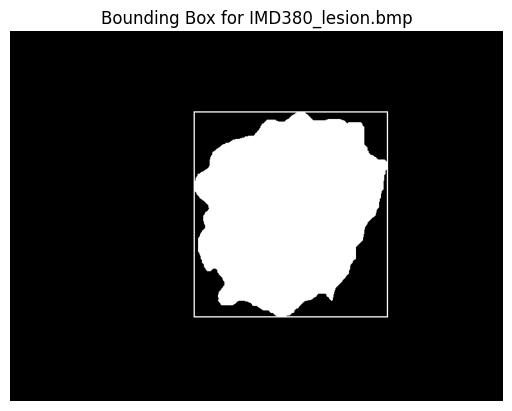

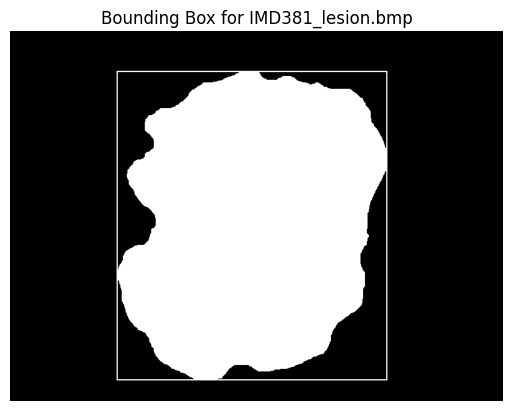

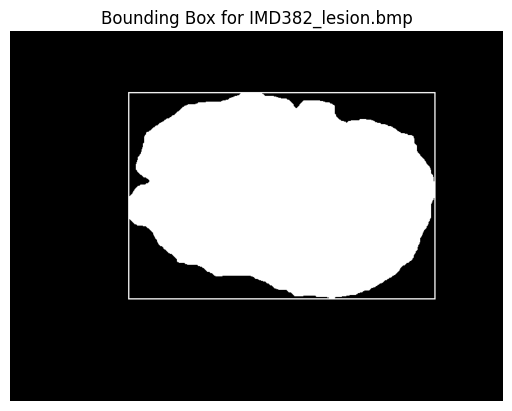

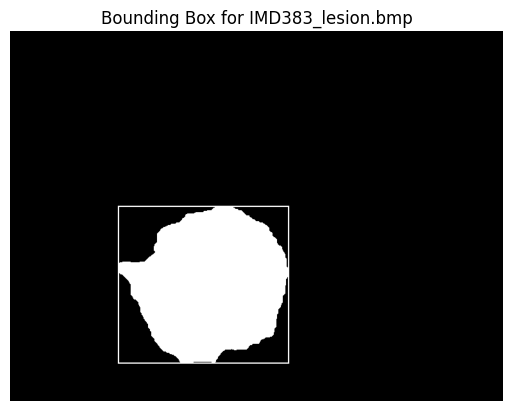

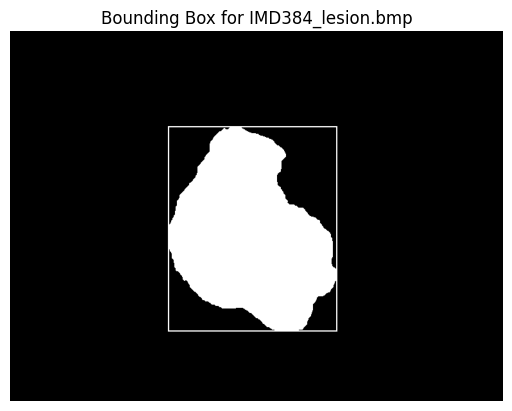

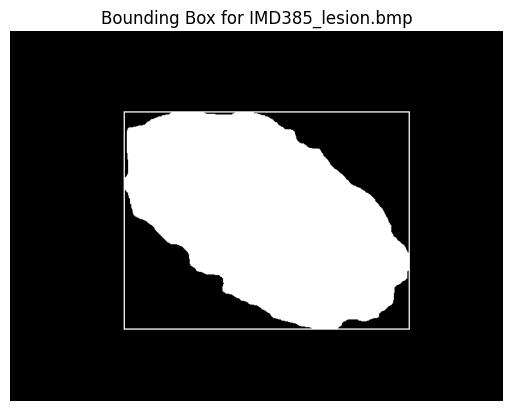

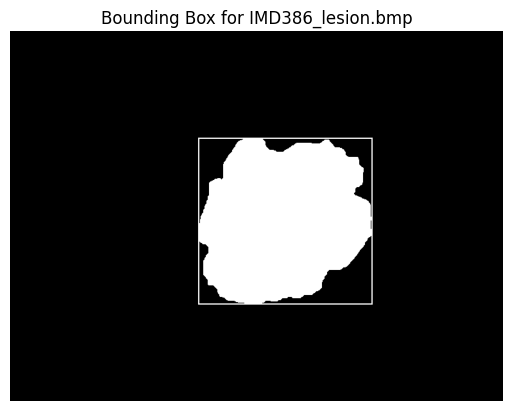

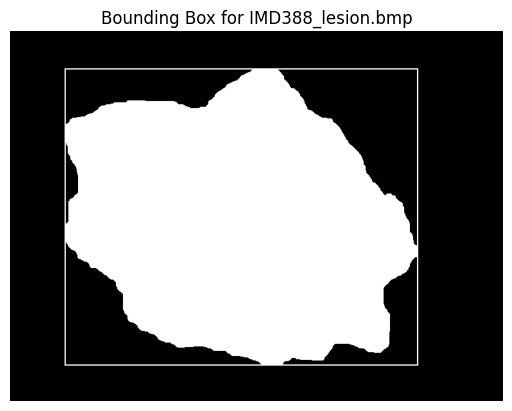

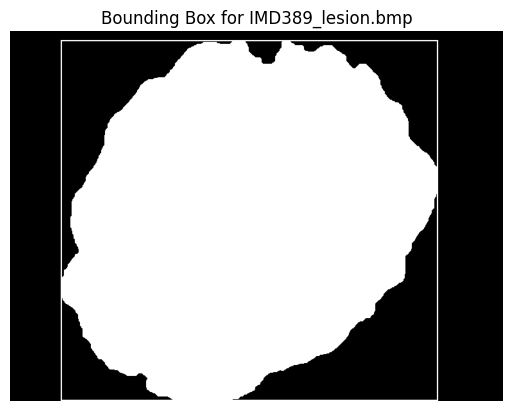

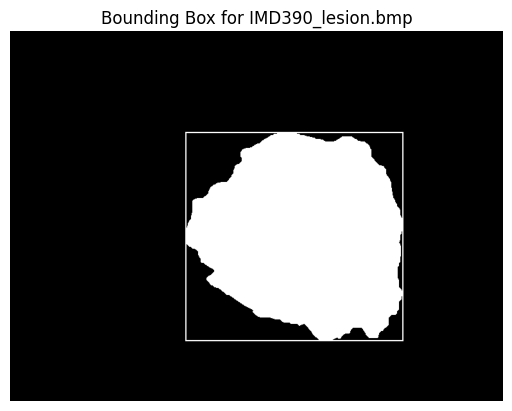

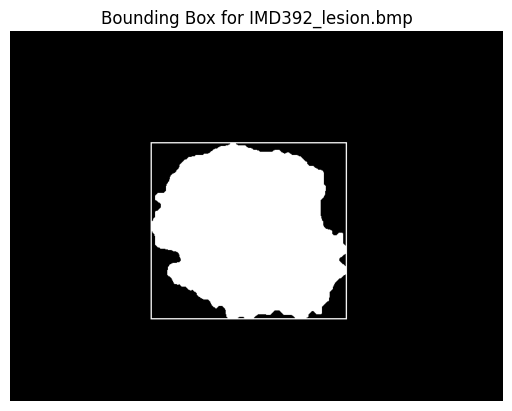

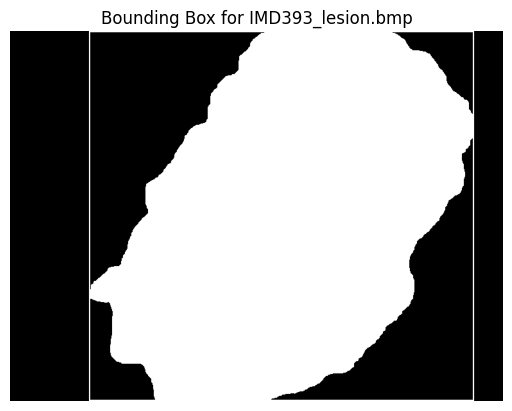

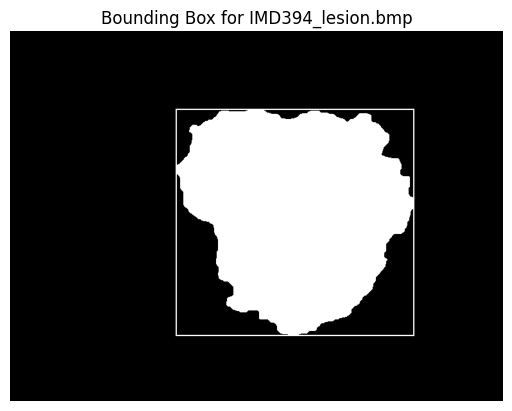

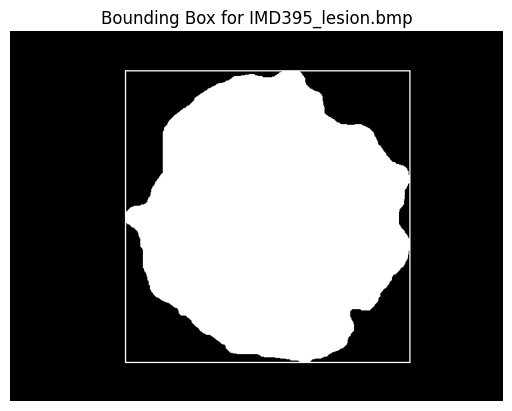

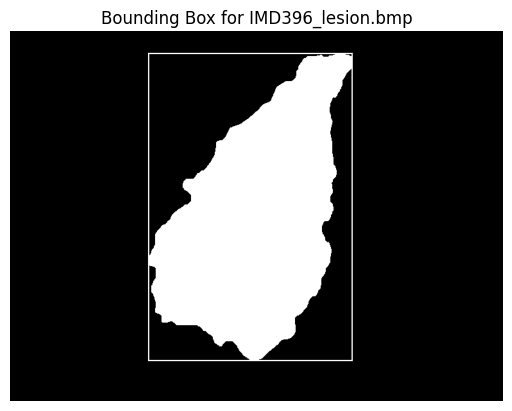

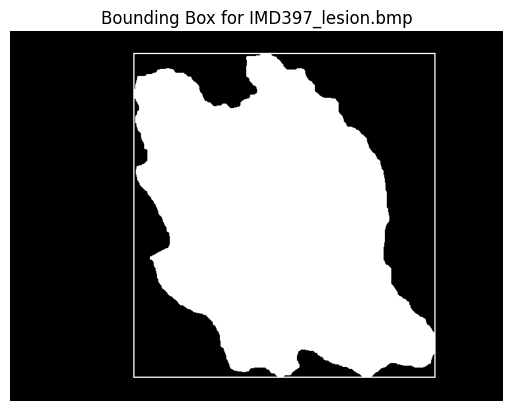

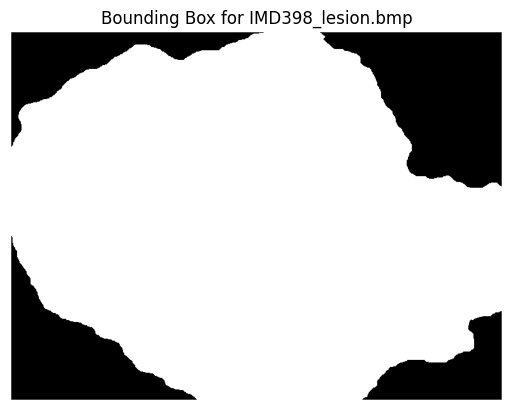

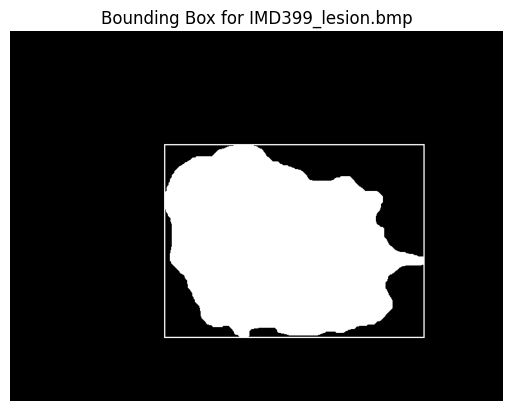

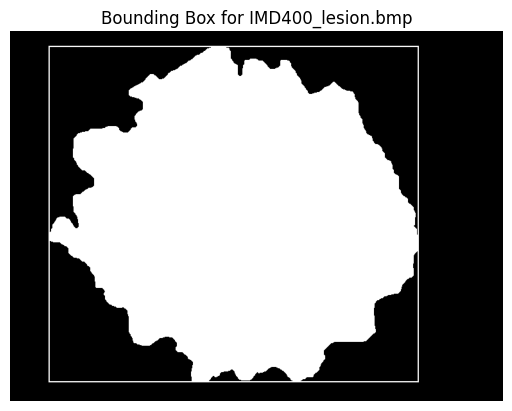

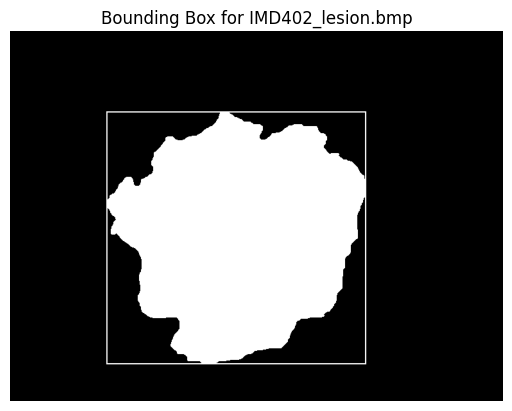

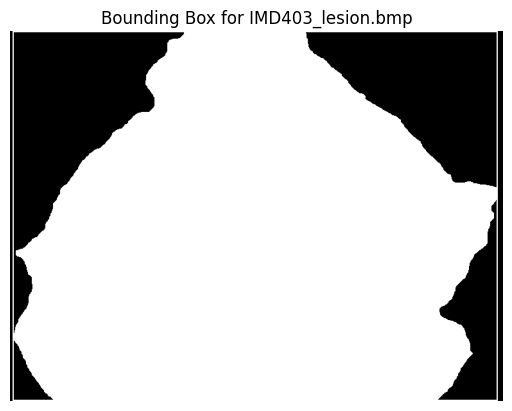

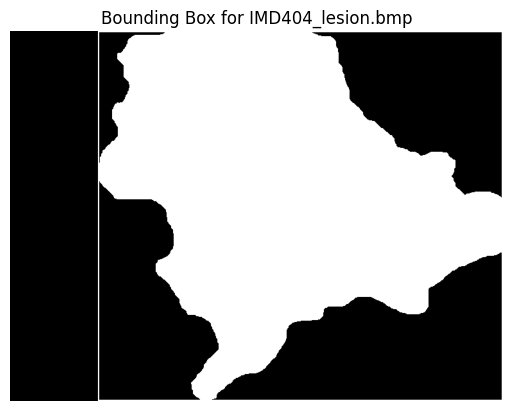

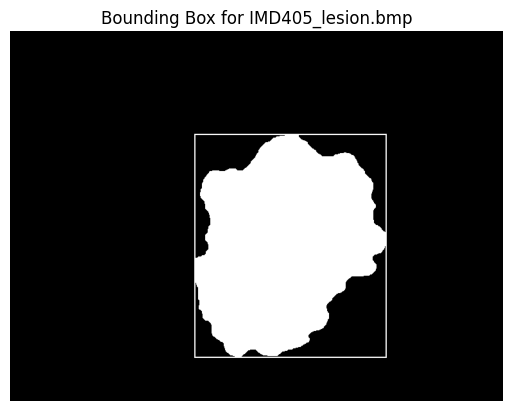

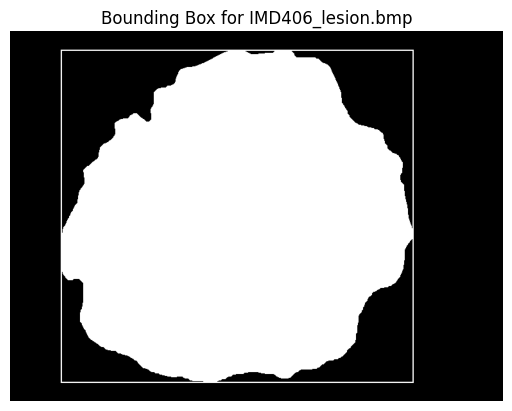

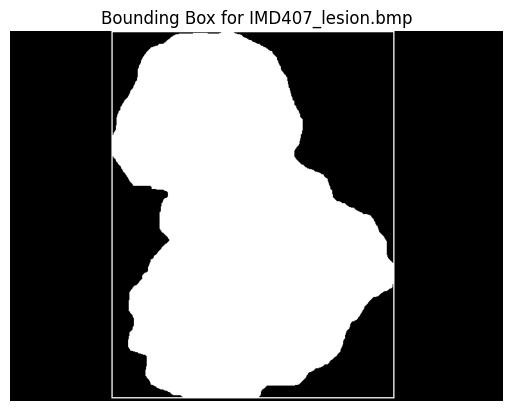

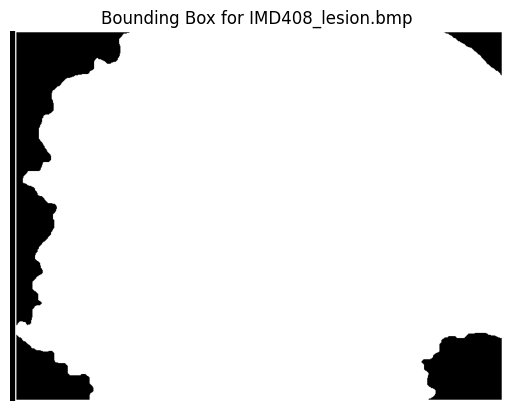

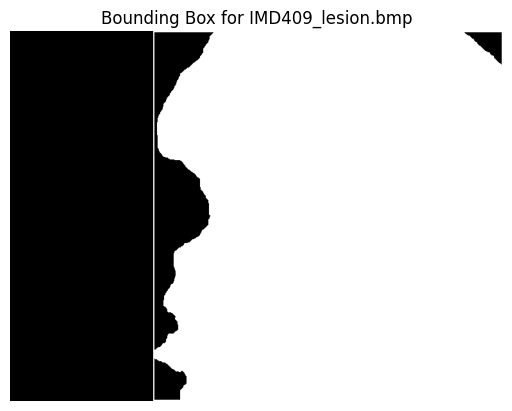

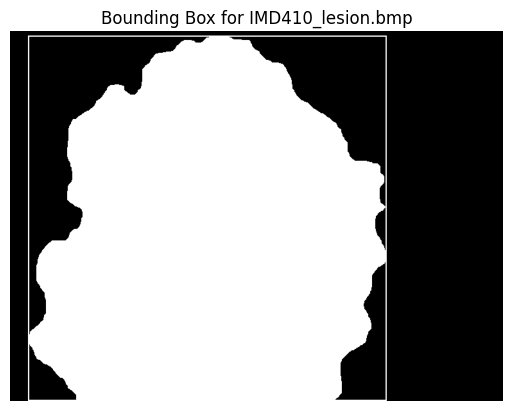

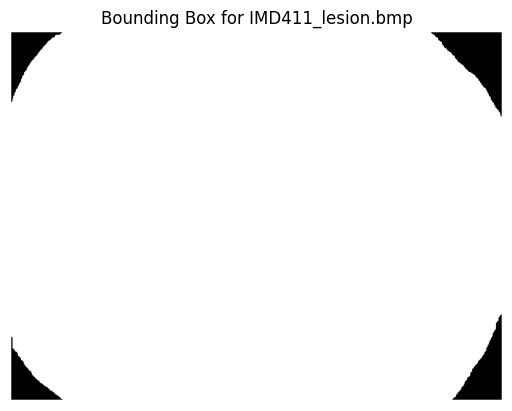

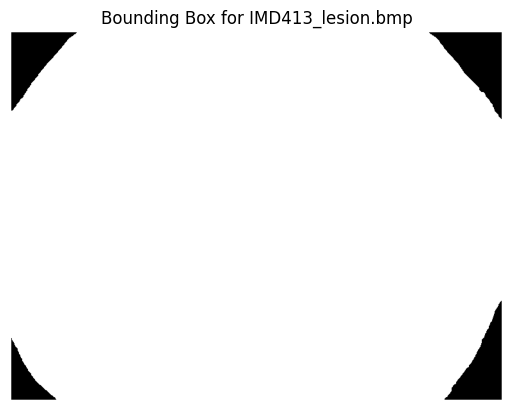

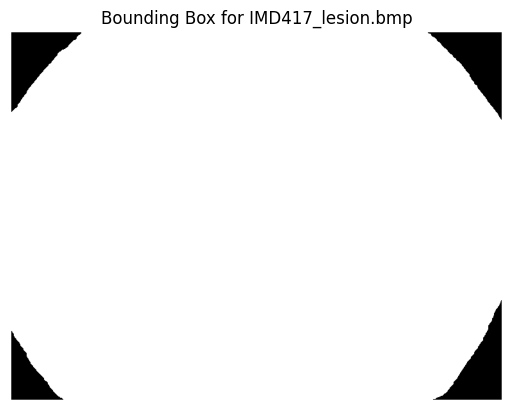

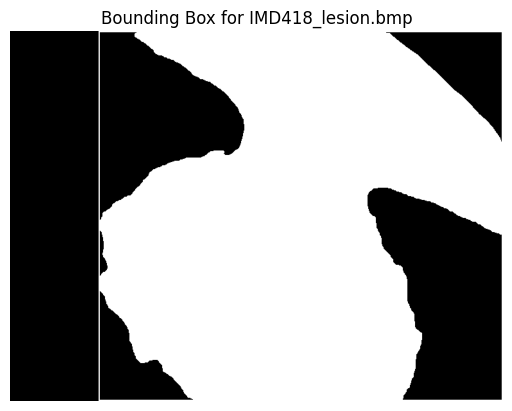

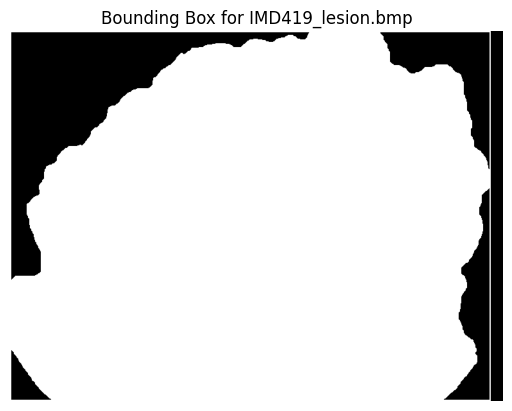

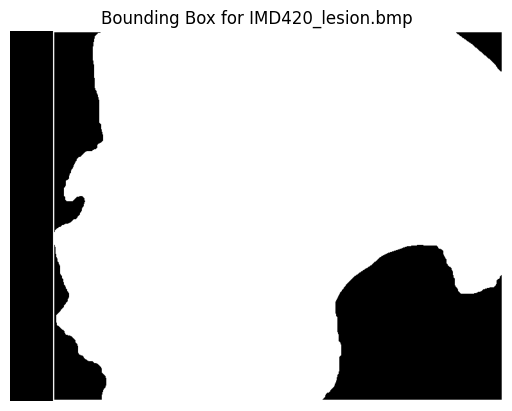

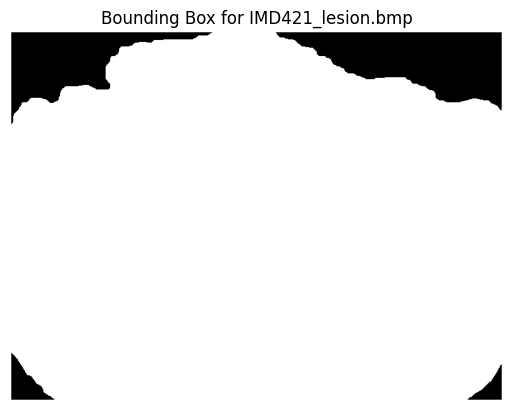

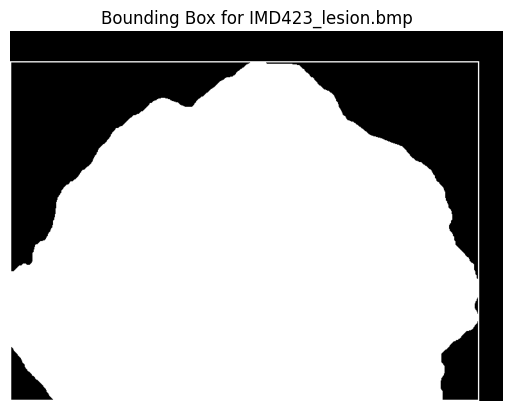

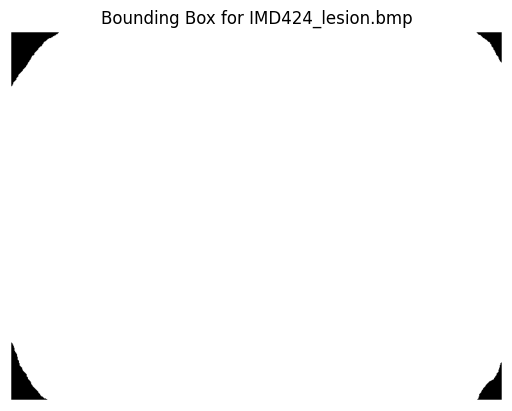

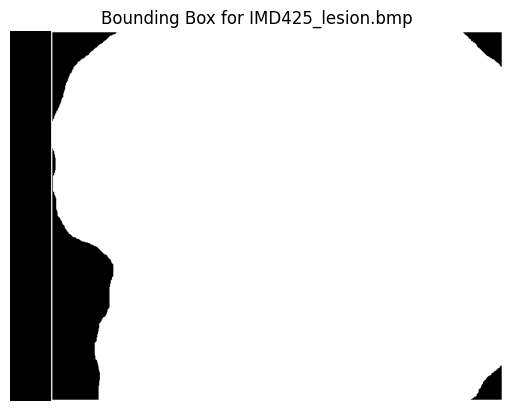

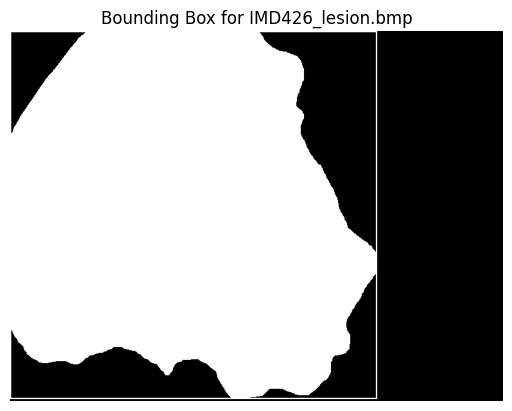

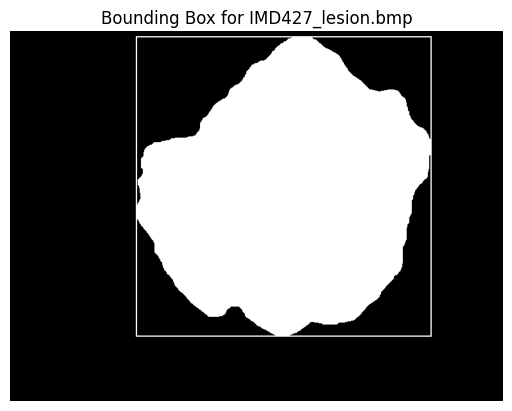

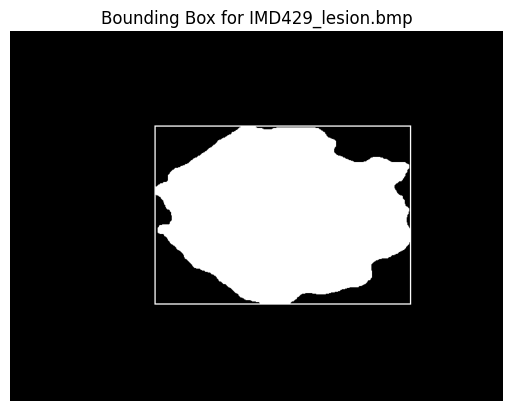

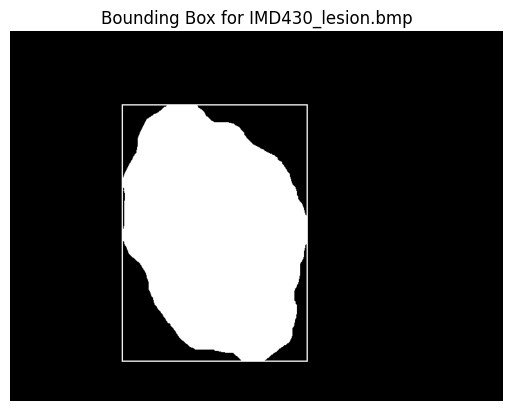

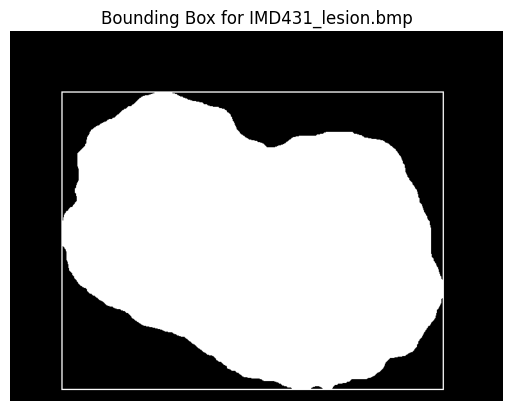

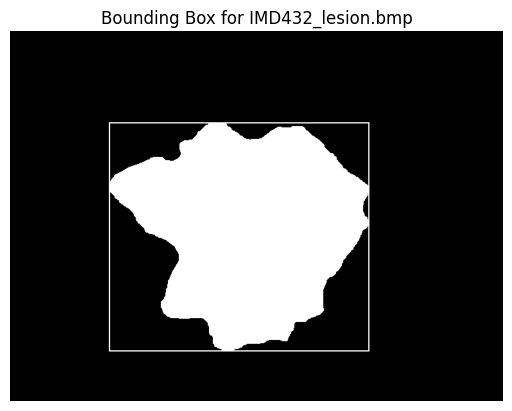

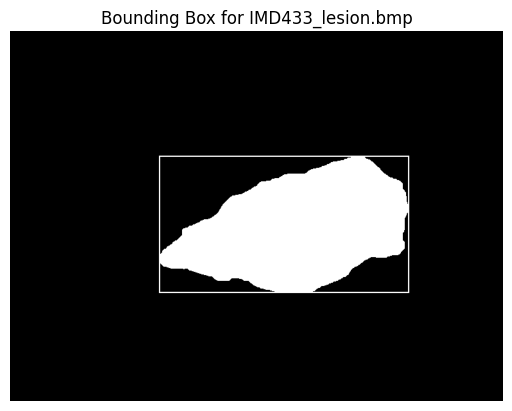

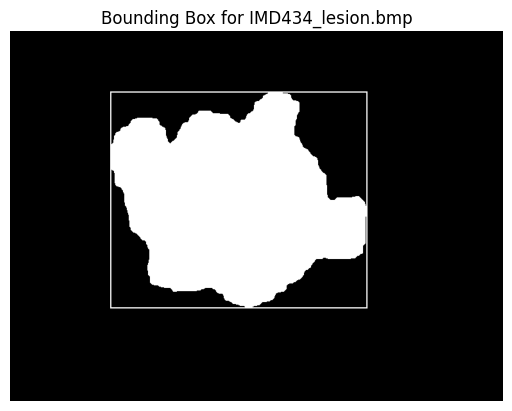

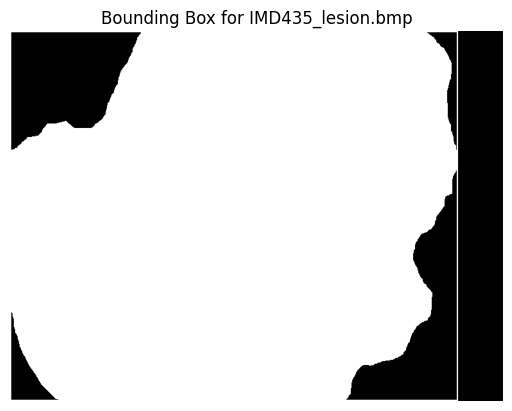

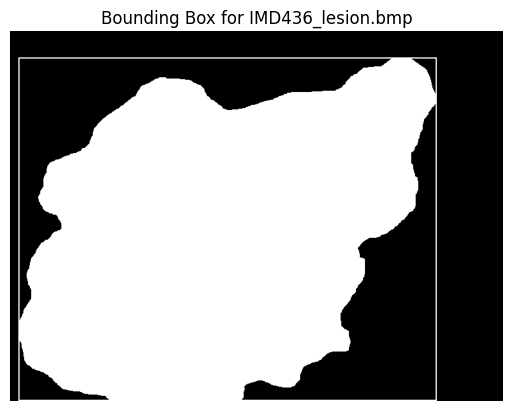

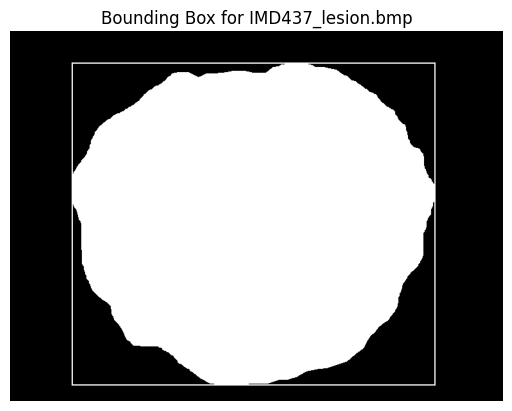

In [25]:
# 1. Load images from path pattern
image_paths = glob.glob(pattern)

# 2. Read image, get bounding box coordinates, and visualize
bounding_boxes = []
for image_path in image_paths:
    # 2.1 Read & resize image
    image = Image.open(image_path)
    image_np = np.array(image)
    if resize_dim is not None:
        resize_transform = transforms.Resize(resize_dim, interpolation=InterpolationMode.NEAREST)
        resized_binary_mask = resize_transform(image)
        image_np = np.array(resized_binary_mask)

    # 2.2 Get bounding box coordinates using weak_annotator
    bounding_boxes_for_given_image = weak_annotator.image_to_bounding_box(image_np)
    relative_path = os.path.relpath(image_path, start=base_path)
    for min_x, min_y, max_x, max_y in bounding_boxes_for_given_image:
        bounding_boxes.append({
            "image_path": relative_path,
            "min_x": min_x,
            "min_y": min_y,
            "max_x": max_x,
            "max_y": max_y
        })

        # 2.3 Visualize bounding box on the image
        image_pil = Image.fromarray(image_np)
        draw = ImageDraw.Draw(image_pil)
        draw.rectangle([min_x, min_y, max_x, max_y], outline="red", width=2)
        plt.imshow(image_pil)
        plt.title(f'Bounding Box for {os.path.basename(image_path)}')
        plt.axis('off')
        plt.show()


In [26]:
# 3. Export data to csv
box_df = pd.DataFrame(bounding_boxes)

# 4. Save the DataFrame
box_df.to_csv("bounding_boxes.csv", index=False)

box_df

,image_path,min_x,min_y,max_x,max_y
0,IMD002\IMD002_lesion\IMD002_lesion.bmp,240,86,618,522
1,IMD003\IMD003_lesion\IMD003_lesion.bmp,173,127,427,409
2,IMD004\IMD004_lesion\IMD004_lesion.bmp,159,120,512,485
3,IMD006\IMD006_lesion\IMD006_lesion.bmp,368,118,675,507
4,IMD008\IMD008_lesion\IMD008_lesion.bmp,260,136,556,408
...,...,...,...,...,...
195,IMD433\IMD433_lesion\IMD433_lesion.bmp,232,194,621,407
196,IMD434\IMD434_lesion\IMD434_lesion.bmp,156,94,556,431
197,IMD435\IMD435_lesion\IMD435_lesion.bmp,0,0,697,575
198,IMD436\IMD436_lesion\IMD436_lesion.bmp,13,41,664,575


## 3. Region growing

In [54]:
# 0. Load point annotations from .npy
point_annotations = np.load('../point_data/1point/IMD006_points.npy')

# 1. Read image corresponding to point annotations
image_path = os.path.join(base_path, 'IMD006', 'IMD006_lesion', 'IMD006_lesion.bmp')

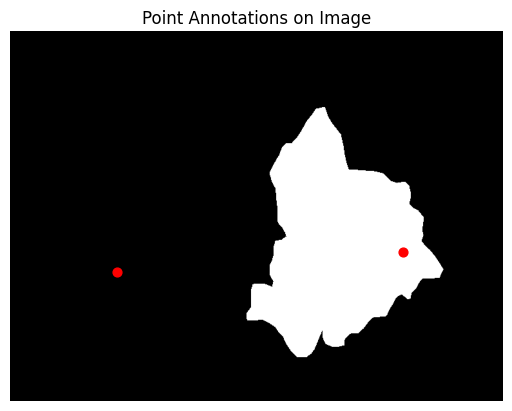

In [56]:
# 2. Plot image with point annotations
image = Image.open(image_path)
# resize_transform = transforms.Resize(resize_dim, interpolation=InterpolationMode.NEAREST)
# resized_binary_mask = resize_transform(image)
image_np = np.array(image)

image_pil = Image.fromarray(image_np)
draw = ImageDraw.Draw(image_pil)
plt.imshow(image_pil)
plt.scatter(point_annotations[:, 1], point_annotations[:, 0], c='red', s=40)
plt.title('Point Annotations on Image')
plt.axis('off')
plt.show()

In [47]:
point_annotations

array([[319, 487],
       [479, 541]], dtype=int32)